In [231]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys
import string

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-04 20:00:00    305.3    305.3   305.3     305.3      149.0
2022-02-04 19:59:00    305.2    305.2   305.2     305.2      571.0


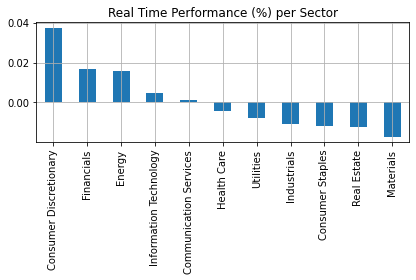

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

137.1500


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
128     DGRO
129     TD6C
130     TDG0
131    PTTRX
132      NaN
Name: Ticker, Length: 133, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
11-Feb
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb
16-Mar
04-Feb - UP (64.9900)
17-Feb
27-Jan - UP (319.1700)
09-Feb
14-Mar
09-Mar
17-Feb
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
14-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb
22-Feb
09-Feb
09-Feb
28-Feb
23-Feb
15-Feb
16-Feb
26-Jan - UP (228.2200)
16-Feb
21-Feb
28-Feb
23-Feb
07-Feb
22-Feb
14-Feb
08-Feb
28-Feb
08-Feb
03-Feb - UP (138.1800)
08-Feb
10-Feb
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb
21-Mar
08-Mar
02-Mar
22-Feb
10-Feb
22-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
14-Feb
16-Feb
15-Feb
23-Feb
17-Feb
01-Mar
28-Feb
23-Feb
14-Feb
10-Feb
21-Feb
01-Feb - UP (128.4400)
18-Feb
01-Mar
02-Feb - DN (237.7600)
21-Feb
01-Mar
22-Mar
14-Feb
22-Feb
23-Feb
23-Feb
08-Feb
09-Feb
22-Feb
23-Feb
03-Feb - UP (38.9100)
09-Feb
16-Feb
27-Jan - UP (170.3300)
26-Jan - UP (528.6900)
22-Mar
17-Mar
23-Feb
05-Feb
10-Feb
23-Feb
09-

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [119]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [198]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace("•", np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("•", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [92]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [95]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1699838/000095017021001629/cflt-20210805ex99_1.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  (IN MILLIONS, EXCEPT PER SHARE DATA)
ORIGINAL TABLE  0
                                       0        1        2           3
0                                    NaN      NaN      NaN         NaN
1                                    NaN  Q2 2021  Q2 2020  Y/Y Change
2                          Total Revenue    $88.3    $53.9         64%
3      Remaining Performance Obligations   $327.2   $190.6         72%
4                    GAAP Operating Loss  $(86.0)  $(27.5)     $(58.5)
5                Non-GAAP Operating Loss  $(36.8)  $(20.4)     $(16.4)
6                GAAP Net Loss Per Share  $(0.74)  $(0.25)     $(0.49)
7            Non-GAAP Net Loss Per Share  $(0.31)  $(0.19)     $(0.12)
8  Net Cash Used in Operating Activities  $(43.2)  $(21.5)     $(21.7)
9                         Free Cash Flow  $(45.4)  $(22.7)     $(22.7)
HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                  METRIC  Q2 2021  Q2 2020 Y/Y CHANGE

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                      NON-CASH OPERATING LEASE COSTS   
10           COMMON STOCK CHARITABLE DONATION EXPENSE   
11  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
12                              DEFERRED INCOME TAXES   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHE

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP OPERATING LOSS TO NON-G...   
4                      OPERATING LOSS ON A GAAP BASIS   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6   ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
7        ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
8                             NON-GAAP OPERATING LOSS   
9                           NON-GAAP OPERATING MARGIN   
11  RECONCILIATION OF GAAP NET LOSS TO NON-GAAP NE...   
12                           NET LOSS ON A GAAP BASIS   
13               ADD STOCK-BASED COMPENSATION EXPENSE   
14  ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
15       ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
16             ADD INCOME TAX EFFECTS AND ADJUSTMENTS   
17                                  NON-GAAP NET LOSS   
18  NON-GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CO...   
19  WEIGHTED

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

Earning for stock UPST will be released later on 2022-02-15
None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [249]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Earning report for stock ENB on date 2022-02-11 does not exist, trying to fetch it
Earning report for stock ENB fetching status False, filename None
Quote for stock ENB on earning date 11-Feb not generated yet
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Earning for stock KNSL will be released later on 2022-02-17
Quote for stock KNSL on earning date 17-Feb not generated yet
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Earning for stock APPN will be released later o

Update Stock ACB with quote 10-Feb - DN (4.4900)
Earning for stock JMIA will be released later on 2022-02-22
Quote for stock JMIA on earning date 22-Feb not generated yet
Earning for stock BYND will be released later on 2022-02-23
Quote for stock BYND on earning date 23-Feb not generated yet
Quote for stock SNAP on earning date 03-Feb - UP (38.9100) already generated
Quote for stock UBER on earning date 09-Feb - DN (37.7500) already generated
Earning for stock ROKU will be released later on 2022-02-16
Quote for stock ROKU on earning date 16-Feb not generated yet
Quote for stock AAPL on earning date 27-Jan - UP (170.3300) already generated
Quote for stock NOW on earning date 26-Jan - UP (528.6900) already generated
Earning for stock ADBE will be released later on 2022-03-22
Quote for stock ADBE on earning date 22-Mar not generated yet
Earning for stock FDX will be released later on 2022-03-17
Quote for stock FDX on earning date 17-Mar not generated yet
Earning for stock CRM will be rele

In [44]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [218]:
stocks = get_earningDates(d, "YT")
print(stocks, "\n", len(stocks))

[['INMD', '10-Feb-2022'], ['BIO', '10-Feb-2022'], ['HUBS', '10-Feb-2022'], ['CFLT', '10-Feb-2022']] 
 4


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [47]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [48]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [49]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [50]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [51]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [52]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [53]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [54]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [55]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [56]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [57]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [58]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [59]:
def isBold(tag, ctext):
    if(tag.name == "b" or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [60]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tag))
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [61]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [121]:
def isPadLeft(item):
    if(item.name == "ul"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [63]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [157]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    if not txt:
        if(item.name == "ul"):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", "")
    ctext = ctext.replace("     ", "")
    ctext = ctext.replace("    ", "")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name != "ul" and item.parent.name != "ul"):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [65]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [240]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle)
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk])
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            ndata = ndata.replace("non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata)
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr)
    f.write("\n")
    return possibleTblTitle

In [241]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    dollarCol = list()
    f.write("\n")
    f.write(tblStr)
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            continue
        nanCnt = 0
        met = string.capwords(met.lower())
        if("Non-gaap" in met):
            met = met.replace("Non-gaap", "Non-GAAP")
        if("Gaap" in met):
            met = met.replace("Gaap", "GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                newcol = string.capwords(newcol.lower())
                if("Non-gaap" in newcol):
                    newcol = newcol.replace("Non-gaap", "Non-GAAP")
                if("Gaap" in newcol):
                    newcol = newcol.replace("Gaap", "GAAP")
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\)-\(', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met.upper() and "PER SHARE" not in met.upper() and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + " " + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + " " + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met.upper() or "EPS" in met.upper())):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
            else:
                header = header + " " + met
        elif(met == "TOTAL"):
            header = None
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr)
    f.write("\n")

In [242]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul"):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [243]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2019-11-12"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [252]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477333/000119312522034540/d243920dex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1404655/000119312519035961/d704859dex991.htm"
source = getPgSource(url)

In [253]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 49

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER 2018: 
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  ● NaN  Total revenue was $144.0 million, up 35% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
   
 ● 
   
   TOTAL REVENUE WAS $144.0 MILLION, UP 35% COMPARED TO Q4’17. 
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  ● NaN  Subscription revenue was $136.8 million, up 35...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
 
   
 ● 
   
   SUBSCRIPTION REVENUE WAS $136.8 MILLION, UP 35% COMPARED TO Q4’17. 
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  ● NaN  Professional services and other revenue was $7...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  FULL YEAR 2018: 
ORIGINAL TABLE  3
    0  1   2                   

HEADERSSSSSSSSS ['0:1']
{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2018  \
3                                              ASSETS               nan   
4                                      CURRENT ASSETS               nan   
5                           CASH AND CASH EQUIVALENTS           $111489   
6                              SHORT-TERM INVESTMENTS            480761   
7                                 ACCOUNTS RECEIVABLE             77100   
8                         DEFERRED COMMISSION EXPENSE             23664   
9                                     RESTRICTED CASH              5175   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS             14229   
12                               TOTAL CURRENT ASSETS            712418   
13                              LONG-TERM INVESTMENTS             11450   
14                        PROPERTY AND EQUIPMENT, NET             52468   
15        CAPITALIZED SOFTWARE DEVELOPMENT CO

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8               DEFERRED INCOME TAX EXPENSE (BENEFIT)   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10                         ACCRETION OF BOND DISCOUNT   
11                               NONCASH RENT EXPENSE   
12                    UNREALIZED CURRENCY TRANSLATION   
13  CHANGES IN ASSETS AND LIABILITIES, NET OF ACQU...   
14                                ACCOUNTS RECEIVABLE   
15                  PREPAID EXPENSES AND OTHER ASSETS   
16                        DEFERRED COMMISSION EXPENSE   
17                                   ACCOUNTS PAYABLE   
18     ACCRUED EXPENS

HEADERSSSSSSSSS ['0:2', '10:12']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                     STOCK -BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED DECEMBER 31, 2018 COS,SUBSCRIPTION  \
4                                              $19742      
5                                                (491      
6                                                (800      
7                                                 nan      
9                                              $18451      
12

HEADERSSSSSSSSS ['0:1']
{2: [3, 4], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
3                                 GAAP NET LOSS RANGE   
4                            STOCK-BASED COMPENSATION   
5          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                        ACQUISITION RELATED EXPENSES   
7   NON-CASH INTEREST EXPENSE FOR AMORTIZATION OF ...   
8                INCOME TAX EFFECTS OF NON-GAAP ITEMS   
10                          NON-GAAP NET INCOME RANGE   
13        GAAP NET INCOME PER BASIC AND DILUTED SHARE   
14               NON-GAAPNET INCOME PER DILUTED SHARE   
16  WEIGHTED AVERAGE COMMON SHARES USED IN COMPUTI...   
18  WEIGHTED AVERAGE COMMON SHARES USED IN COMPUTI...   

   NAN THREE MONTHS ENDEDMARCH 31, 2019 NAN YEAR ENDEDDECEMBER 31, 2019  
3                     ($16730)-($15730)                  ($79930-75930)  
4                                 20700                          104000  
5                               

In [254]:
allTables

{'TOTAL': 49,
 'PARSESUCCESS': [33, 34, 35, 36, 37, 38, 39, 40],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 0: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Total revenue was $144.0\\u00a0million, up 35% compared to Q4\\u201917."}]'},
 1: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Subscription revenue was $136.8\\u00a0million, up 35% compared to Q4\\u201917."}]'},
 2: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Professional services and other revenue was $7.2\\u00a0million, up 49% compared to Q4\\u201917."}]'},
 3: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Total revenue was $513.0\\u00a0million, up 37% compared to 2017."}]'},
 4: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Subscription revenue was $487.5\\u00a0million, up 37% compared t

In [255]:
csym = "HUBS"
#rptDest = "../../Summary/EDGAR/8-K/"+csym
#textFilename = rptDest+"/NET_2022-02-10_EP.txt"
#testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
testOne8KEdgarRpt(url, csym, None, source, allTables)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/HUBS'
NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q4 and Full Year 2018 Results.


SC*** CAMBRIDGE, MA (February 12, 2019) — HubSpot, Inc. (NYSE: HUBS), a leading growth platform, today announced financial results for the fourthquarter and full year ended December 31, 2018.


SC*** Financial Highlights:.


SC*** Revenue.

NOPAD*** Fourth Quarter 2018:.

TABLEEEEEEEEEEE 0
● Total revenue was $144.0 million, up 35% compared  Q4’17.
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
● Subscription revenue was $136.8 million, up 35% compared  Q4’17.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
● Professional services and other revenue was $7.2 million, up 49% compared  Q4’17.
TABLEEEE CNTTTTT 3
NOPAD*** Full Year 2018:.

TABLEEEEEEEEEEE 3
● Total revenue was $513.0 million, up 37% compared  2017.
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
● Subscription revenue was $487.5 million, up 37% compared  2017.
TAB

In [206]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [256]:
csym = "HUBS"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/HUBS'
1404655
8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001193125-19-035961-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1404655/000119312519035961/d704859dex991.htm
NUMBER OF TABLES 49

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER 2018: 
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  ● NaN  Total revenue was $144.0 million, up 35% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
   
 ● 
   
   TOTAL REVENUE WAS $144.0 MILLION, UP 35% COMPARED TO Q4’17. 
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  ● NaN  Subscription revenue was $136.8 million, up 35...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
 
   
 ● 
   
   SUBSCRIPTION REVENUE WAS $136.8 MILLION, UP 35% COMPARED TO Q4’17. 
ORIGINAL T

HEADERSSSSSSSSS ['0:1']
{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2018  \
3                                              ASSETS               nan   
4                                      CURRENT ASSETS               nan   
5                           CASH AND CASH EQUIVALENTS           $111489   
6                              SHORT-TERM INVESTMENTS            480761   
7                                 ACCOUNTS RECEIVABLE             77100   
8                         DEFERRED COMMISSION EXPENSE             23664   
9                                     RESTRICTED CASH              5175   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS             14229   
12                               TOTAL CURRENT ASSETS            712418   
13                              LONG-TERM INVESTMENTS             11450   
14                        PROPERTY AND EQUIPMENT, NET             52468   
15        CAPITALIZED SOFTWARE DEVELOPMENT CO

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8               DEFERRED INCOME TAX EXPENSE (BENEFIT)   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10                         ACCRETION OF BOND DISCOUNT   
11                               NONCASH RENT EXPENSE   
12                    UNREALIZED CURRENCY TRANSLATION   
13  CHANGES IN ASSETS AND LIABILITIES, NET OF ACQU...   
14                                ACCOUNTS RECEIVABLE   
15                  PREPAID EXPENSES AND OTHER ASSETS   
16                        DEFERRED COMMISSION EXPENSE   
17                                   ACCOUNTS PAYABLE   
18     ACCRUED EXPENS

HEADERSSSSSSSSS ['0:2', '10:12']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                     STOCK -BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED DECEMBER 31, 2018 COS,SUBSCRIPTION  \
4                                              $19742      
5                                                (491      
6                                                (800      
7                                                 nan      
9                                              $18451      
12

FINAL REPORT
                                       METRIC  \
3                 GAAP OPERATING INCOME RANGE   
4                    STOCK-BASED COMPENSATION   
5  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                ACQUISITION RELATED EXPENSES   
8             NON-GAAP OPERATING INCOME RANGE   

  NAN THREE MONTHS ENDEDMARCH, 31 2019 NAN YEAR ENDEDDECEMBER 31, 2019  
3                    ($12030)-($11030)               ($61230)-($57230)  
4                                20700                          104000  
5                                  800                            3100  
6                                   30                             130  
8                         $9500-$10500                   $46000-$50000  

FOR TABLE 40

TABLE DESCRIPTION:  
ORIGINAL TABLE  40
                                                    0  \
0                                                 NaN   
1   Reconciliation of forecasted non-GAAP net inco...   
2                           

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q4 and Full Year 2018 Results.


SC*** CAMBRIDGE, MA (February 12, 2019) — HubSpot, Inc. (NYSE: HUBS), a leading growth platform, today announced financial results for the fourthquarter and full year ended December 31, 2018.


SC*** Financial Highlights:.


SC*** Revenue.

NOPAD*** Fourth Quarter 2018:.

TABLEEEEEEEEEEE 0
● Total revenue was $144.0 million, up 35% compared  Q4’17.
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
● Subscription revenue was $136.8 million, up 35% compared  Q4’17.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
● Professional services and other revenue was $7.2 million, up 49% compared  Q4’17.
TABLEEEE CNTTTTT 3
NOPAD*** Full Year 2018:.

TABLEEEEEEEEEEE 3
● Total revenue was $513.0 million, up 37% compared  2017.
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
● Subscription revenue was $487.5 million, up 37% compared  2017.
TABLEEEE CNTTTTT 5
TABLEEEEEEEEEEE 5
● Professional services and other revenue was $25.5 million, up 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 12

TABLE DESCRIPTION:  
 
   
 ● 
   
   THE COMPANY’S CASH, CASH EQUIVALENTS AND INVESTMENTS BALANCE WAS $983.7 MILLION AS OF MARCH 31,
2019. 
ORIGINAL TABLE  12
    0  1   2                                                  3
0 NaN  ● NaN  During the first quarter, the company generate...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 13

TABLE DESCRIPTION:  ADDITIONAL RECENT BUSINESS HIGHLIGHTS 
ORIGINAL TABLE  13
    0  1   2                                                  3
0 NaN  ● NaN  Grew total customers to 60,814 at March 31, 20...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 14

TABLE DESCRIPTION:  
 
   
 ● 
   
   GREW TOTAL CUSTOMERS TO 60,814 AT MARCH 31, 2019 UP 35% FROM MARCH 31, 2018. 
ORIGINAL TABLE  14
    0  1   2                                                  3
0 NaN  ● NaN  Total average subscription revenue per custome...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT 

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
3                                 OPERATINGACTIVITIES   
4                                             NETLOSS   
5   ADJUSTMENTSTORECONCILENETLOSSTONETCASHANDCASH ...   
6                         DEPRECIATIONANDAMORTIZATION   
7                             STOCK-BASEDCOMPENSATION   
8                       BENEFITFORDEFERREDINCOMETAXES   
9          AMORTIZATIONOFDEBTDISCOUNTANDISSUANCECOSTS   
10                            ACCRETIONOFBONDDISCOUNT   
11                                NONCASHLEASEEXPENSE   
12                      UNREALIZEDCURRENCYTRANSLATION   
13                      CHANGESINASSETSANDLIABILITIES   
14                                 ACCOUNTSRECEIVABLE   
15                      PREPAIDEXPENSESANDOTHERASSETS   
16                          DEFERREDCOMMISSIONEXPENSE   
17                                 RIGHT-OF-USEASSETS   
18                       

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                      STOCK-BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED MARCH 31, 2019 COS,SUBSCRIPTION  \
4                                              $21301   
5                                                (614   
6                                                (800   
7                                                 nan   
9                                              $19887   
12                                              14.0%

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION:   
ORIGINAL TABLE  31
    0   1                                                  2
0 NaN  C.  Acquisition related expenses, such as transact...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION:   
ORIGINAL TABLE  32
    0   1                                                  2
0 NaN  D.  In May 2017, the Company issued $400 million o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 33

TABLE DESCRIPTION:   
ORIGINAL TABLE  33
    0   1                                                  2
0 NaN  E.  The effects of income taxes on non-GAAP items ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1404655/000119312519139680/d745582dex991.htm
8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001193125-19-164683-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1404655

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                        SUBSCRIPTION   
5                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
9                                    COST OF REVENUES   
10                                       SUBSCRIPTION   
11                    PROFESSIONAL SERVICES AND OTHER   
13                             TOTAL COST OF REVENUES   
15                                       GROSS PROFIT   
17                                 OPERATING EXPENSES   
18                           RESEARCH AND DEVELOPMENT   
19                                SALES AND MARKETING   
20                         GENERAL AND ADMINISTRATIVE   
22                           TOTAL OPERATING EXPENSES   
24                               LOSS FROM OPERATIONS   
26                   

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                        METRIC  \
3                          GAAP OPERATING LOSS   
4                     STOCK-BASED COMPENSATION   
5   AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                 ACQUISITION RELATED EXPENSES   
8                    NON-GAAP OPERATING INCOME   
10                       GAAP OPERATING MARGIN   
11                   NON-GAAP OPERATING MARGIN   

   THREE MONTHS ENDEDJUNE 30, 2019 THREE MONTHS ENDEDJUNE 30, 2018  \
3                          $(15725                         $(14052   
4                            28663                           19675   
5                              800                              50   
6                               32                             802   
8                           $13770                           $6475   
10                            (9.6                           (11.5   
11                            8.4%        


FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                     STOCK -BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
11      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
12  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED JUNE 30, 2019 COS,SUBSCRIPTION  \
4                                             $23578   
5                                               (822   
6                                               (800   
7                                                nan   
9                                             $21956   
11                                             14.4%   
12                                             13.4%   

   THREE MONTHS ENDED JUNE 30, 2019 COS,PROF.SERVICES &OTHER  \
4                                               $7564          


HEADERSSSSSSSSS ['0:0']
{1: [1], 4: [4]}

FINAL REPORT
                                       METRIC  \
2                 GAAP OPERATING INCOME RANGE   
3                    STOCK-BASED COMPENSATION   
4  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
5                ACQUISITION RELATED EXPENSES   
7             NON-GAAP OPERATING INCOME RANGE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 YEAR ENDEDDECEMBER 31, 2019  
2                       16880)-($15880              49330)-($48330  
3                                24100                      100100  
4                                  750                        3100  
5                                   30                         130  
7                          $8000-$9000               $54000-$55000  

FOR TABLE 30

TABLE DESCRIPTION:   
ORIGINAL TABLE  30
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN 

8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001564590-19-040451-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1404655/000156459019040451/hubs-ex991_6.htm
NUMBER OF TABLES 37

FOR TABLE 0

TABLE DESCRIPTION:  REVENUE
ORIGINAL TABLE  0
    0  1                                                  2
0 NaN  ●  Total revenue was $173.6 million, up 32% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
 
 
   
 
 ● 
 
 TOTAL REVENUE WAS $173.6 MILLION, UP 32% COMPARED TO Q3’18.
ORIGINAL TABLE  1
    0  1                                                  2
0 NaN  ●  Subscription revenue was $167.1 million, up 33...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
 
 
 
   
 
 ● 
 
 SUBSCRIPTION REVENUE WAS $167.1 MILLION, UP 33% COMPARED TO Q3’18.
ORIGINAL TABLE  2
    0  1                                                  2
0 NaN  ●  Professional services and other revenue was $6...
HEADERS

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS 

{1: [2], 4: [5], 7: [8], 10: [11]}

FINAL REPORT
                                       METRIC  \
2                         GAAP OPERATING LOSS   
3                    STOCK-BASED COMPENSATION   
4  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
5                ACQUISITION RELATED EXPENSES   
6                   NON-GAAP OPERATING INCOME   
8                       GAAP OPERATING MARGIN   
9                   NON-GAAP OPERATING MARGIN   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 THREE MONTHS ENDED SEPTEMBER 30, 2018  \
2                               $(14072                               $(15050   
3                                 23791                                 19612   
4                                   762                                   494   
5                                    30                                   802   
6                                $10511                                 $5858   
8                                  (8.1                                 

{1: [2], 4: [5], 7: [8], 10: [11], 13: [14], 15: [16], 17: [18], 20: [21], 23: [24], 26: [27], 29: [30]}

FINAL REPORT
                                         METRIC  \
5                                  GAAP EXPENSE   
6                     STOCK -BASED COMPENSATION   
7    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
11      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
12  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   NAN THREE MONTHS ENDED SEPTEMBER 30, 2019 COS, SUBSCRIPTION  \
5                                              $25671            
6                                                (854            
7                                                (762            
8                                                 nan            
9                                              $24055            
11                                              14.8%            
12        

HEADERSSSSSSSSS ['0:3']
{2: [3], 5: [6], 8: [9], 11: [12]}

FINAL REPORT
                                              METRIC  \
5  GAAP NET CASH AND CASH EQUIVALENTS PROVIDED BY...   
6                PURCHASES OF PROPERTY AND EQUIPMENT   
7       CAPITALIZATION OF SOFTWARE DEVELOPMENT COSTS   
8                                     FREE CASH FLOW   

  NAN THREE MONTHS ENDED SEPTEMBER 30, 2019  \
5                                    $19669   
6                                     (9141   
7                                     (3811   
8                                     $6717   

  NAN THREE MONTHS ENDED SEPTEMBER 30, 2018  \
5                                    $11517   
6                                     (5378   
7                                     (2920   
8                                     $3219   

  NAN NINE MONTHS ENDED SEPTEMBER 30, 2019  \
5                                   $71082   
6                                   (21197   
7                                   

NOPAD*** hubs-ex991_6.htm.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q3 2019 Results.

NOPAD*** CAMBRIDGE, MA (November 5, 2019) — HubSpot, Inc. (NYSE: HUBS), a leading growth platform, today announced financial results for the third quarter ended September 30, 2019.


SC*** Financial Highlights:.


SC*** Revenue.

TABLEEEEEEEEEEE 0
● Total revenue was $173.6 million, up 32% compared  Q3’18.
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
● Subscription revenue was $167.1 million, up 33% compared  Q3’18.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
● Professional services and other revenue was $6.5 million, up 3% compared  Q3’18.
TABLEEEE CNTTTTT 3

SC*** Operating Income (Loss).

TABLEEEEEEEEEEE 3
● GAAP operating margin was (8.1%), compared  (11.4%) in Q3’18.
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
● Non-GAAP operating margin was 6.1%, an improvement of approximately 1.7 percentage points from 4.4% in Q3’18.
TABLEEEE CNTTTTT 5
TABLEEEEEEEEEEE 5
● GAAP operating loss was ($14.1) million, compared  ($15

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2019  \
2                                              ASSETS               nan   
3                                      CURRENT ASSETS               nan   
4                           CASH AND CASH EQUIVALENTS           $269670   
5                              SHORT-TERM INVESTMENTS            691834   
6                                 ACCOUNTS RECEIVABLE             92517   
7                         DEFERRED COMMISSION EXPENSE             32078   
8                                     RESTRICTED CASH              5816   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS             17809   
10                               TOTAL CURRENT ASSETS           1109724   
11                              LONG-TERM INVESTMENTS             53776   
12                        PROPERTY AND EQUIPMENT, NET             83649   
13        CAPITALIZED SOFTWARE DEVELOPMENT COSTS, NET             167

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5                       DEPRECIATION AND AMORTIZATION   
6                            STOCK-BASED COMPENSATION   
7               DEFERRED INCOME TAX (BENEFIT) EXPENSE   
8    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
9                          ACCRETION OF BOND DISCOUNT   
10                               NONCASH RENT EXPENSE   
11                    UNREALIZED CURRENCY TRANSLATION   
12                  CHANGES IN ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                  PREPAID EXPENSES AND OTHER ASSETS   
15                        DEFERRED COMMISSION EXPENSE   
16                                RIGHT-OF-USE ASSETS   
17                   

{1: [2], 4: [5], 7: [8], 10: [11], 13: [14], 15: [16], 17: [18], 20: [21], 23: [24], 26: [27], 29: [30]}

FINAL REPORT
                                         METRIC  \
5                                  GAAP EXPENSE   
6                      STOCK-BASED COMPENSATION   
7    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
11      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
12  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   NAN THREE MONTHS ENDED DECEMBER 31, 2019 COS, SUBSCRIPTION  \
5                                              $27960           
6                                                (836           
7                                                (839           
8                                                 nan           
9                                              $26285           
11                                              15.0%           
12               

{2: [3], 5: [6], 8: [9], 11: [12]}

FINAL REPORT
                                              METRIC  \
5  GAAP NET CASH AND CASH EQUIVALENTS PROVIDED BY...   
6                PURCHASES OF PROPERTY AND EQUIPMENT   
7       CAPITALIZATION OF SOFTWARE DEVELOPMENT COSTS   
8                                     FREE CASH FLOW   

  NAN THREE MONTHS ENDED DECEMBER 31, 2019  \
5                                   $47891   
6                                   (19175   
7                                    (4335   
8                                   $24381   

  NAN THREE MONTHS ENDED DECEMBER 31, 2018 NAN YEAR ENDED DECEMBER 31, 2019  \
5                                   $33111                          $118973   
6                                    (5617                           (40372   
7                                    (2442                           (13474   
8                                   $25052                           $65127   

  NAN YEAR ENDED DECEMBER 31, 2018  
5     

NOPAD*** hubs-ex991_12.htm.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q4 and Full Year 2019 Results.

NOPAD*** CAMBRIDGE, MA (February 12, 2020) — HubSpot, Inc. (NYSE: HUBS), a leading growth platform, today announced financial results for the fourth quarter and full year ended December 31, 2019.


SC*** Financial Highlights:.


SC*** Revenue.

NOPAD*** Fourth Quarter 2019:.

TABLEEEEEEEEEEE 0
● Total revenue was $186.2 million, up 29% compared  Q4’18.
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
● Subscription revenue was $179.1 million, up 31% compared  Q4’18.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
● Professional services and other revenue was $7.1 million, down 2% compared  Q4’18.
TABLEEEE CNTTTTT 3
NOPAD*** Full Year 2019:.

TABLEEEEEEEEEEE 3
● Total revenue was $674.9 million, up 32% compared  2018.
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
● Subscription revenue was $646.3 million, up 33% compared  2018.
TABLEEEE CNTTTTT 5
TABLEEEEEEEEEEE 5
● Professional services and other revenue was $28.

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 8

TABLE DESCRIPTION:  
 
 
 
   
 
 ● 
 
 W EIGHTED AVERAGE BASIC AND DILUTED SHARES OUTSTANDING FOR GAAP NET LOSS PER SHARE WAS  43.3   MILLION, COMPARED TO   40.6   MILLION BASIC AND DILUTED SHARES IN   Q1'19 .
ORIGINAL TABLE  8
    0  1                                                  2
0 NaN  ●  Weighted average basic and diluted shares outs...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 9

TABLE DESCRIPTION:  BALANCE SHEET AND CASH FLOW
ORIGINAL TABLE  9
    0  1                                                  2
0 NaN  ●  The company’s cash, cash equivalents and inves...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 10

TABLE DESCRIPTION:  
 
 
 
   
 
 ● 
 
 THE COMPANY’S CASH, CASH EQUIVALENTS AND INVESTMENTS BALANCE WAS $1,035 MILLION AS OF MARCH 31, 2020. 
ORIGINAL TABLE  10
    0  1                                                  2
0 NaN  ●  During the first quarter, the company


FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS   
17                                      OTHER EXPENSE   
18               

FOR TABLE 28

TABLE DESCRIPTION:   
ORIGINAL TABLE  28
                                                   0   \
0   Reconciliation of non-GAAP expense and expense...   
1                  (in thousands, except percentages)   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                        GAAP expense   
6                           Stock -based compensation   
7          Amortization of acquired intangible assets   
8                        Acquisition related expenses   
9                                    Non-GAAP expense   
10                                                NaN   
11            GAAP expense as a percentage of revenue   
12        Non-GAAP expense as a percentage of revenue   

                                                   1   \
0   Reconciliation of non-GAAP expense and expense...   
1                  (in thousands

{2: [3], 5: [6]}

FINAL REPORT
                                        METRIC  \
4                     GAAP SUBSCRIPTION MARGIN   
5                    STOCK -BASED COMPENSATION   
6   AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                 NON-GAAP SUBSCRIPTION MARGIN   
9          GAAP SUBSCRIPTION MARGIN PERCENTAGE   
10     NON-GAAP SUBSCRIPTION MARGIN PERCENTAGE   

   NAN THREE MONTHS ENDED MARCH 31, 2020 NAN THREE MONTHS ENDED MARCH 31, 2019  
4                                $161495                               $122925  
5                                    898                                   614  
6                                    880                                   800  
7                                $163273                               $124339  
9                                  84.5%                                 85.2%  
10                                 85.4%                                 86.2%  

FOR TABLE 30

TABLE DESCRIPTION:   
ORIGINAL TABLE

NOPAD*** hubs-ex991_6.htm.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q1 2020 Results.

NOPAD*** CAMBRIDGE, MA (May 6, 2020) — HubSpot, Inc. (NYSE: HUBS), a leading growth platform, today announced financial results for the first quarter ended March 31, 2020.

NOPAD*** “We came into 2020 strong with the relaunch of our Marketing Hub Enterprise and a new CMS product line. While the global economic situation shifted with the onslaught of the COVID-19 health crisis and created some headwinds for us, we feel well positioned to weather this storm,” said Brian Halligan, co-founder and CEO. “Our primary focus now is on doing what we can to help our customers and partners bend, not break, in the face of these tough times.”.

NOPAD*** The company also announced today that JD Sherman, its President and Chief Operating Officer, will be stepping down from his position as of July 1, 2020 but will remain with the Company through January 4, 2021 to ensure a smooth transition of his duties.

NOPAD*

8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001193125-20-157937-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1404655/000119312520157937/d830273dex991.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1404655/000119312520157937/d830273dex991.htm
8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001193125-20-162234-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1404655/0001193125-20-162234-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001564590-20-029650-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1404655/0001564590-20-029650-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001564590-20-036844-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1404655/000156459020036844/hubs-ex991_10.htm
NUMBER OF TABLES 43

FOR TABLE 0

TABLE DESCRIPTION:  REVENUE
ORIGINAL TABLE  0
    0  1                             

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS 

FINAL REPORT
                                       METRIC  \
2                         GAAP OPERATING LOSS   
3                    STOCK-BASED COMPENSATION   
4  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
5                ACQUISITION RELATED EXPENSES   
6                   NON-GAAP OPERATING INCOME   
8                       GAAP OPERATING MARGIN   
9                   NON-GAAP OPERATING MARGIN   

  THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, 2019  \
2                          $(13625                          $(15725   
3                            31374                            28663   
4                              899                              800   
5                              518                               32   
6                            19166                           $13770   
8                             (6.7                             (9.6   
9                             9.4%                             8.4%   

  SIX MONTHS ENDED JUNE 3

FINAL REPORT
                                         METRIC  \
5                                  GAAP EXPENSE   
6                     STOCK -BASED COMPENSATION   
7    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
11      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
12  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   NAN THREE MONTHS ENDED JUNE 30, 2020 COS, SUBSCRIPTION  \
5                                              $30400       
6                                               (1075       
7                                                (879       
8                                                 nan       
9                                              $28446       
11                                              14.9%       
12                                              14.0%       

   NAN THREE MONTHS ENDED JUNE 30, 2020 COS, PROF. SERVICES & OTHER  \
5                 

{2: [3], 5: [6], 8: [9], 11: [12]}

FINAL REPORT
                                        METRIC  \
4                     GAAP SUBSCRIPTION MARGIN   
5                    STOCK -BASED COMPENSATION   
6   AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                 NON-GAAP SUBSCRIPTION MARGIN   
9          GAAP SUBSCRIPTION MARGIN PERCENTAGE   
10     NON-GAAP SUBSCRIPTION MARGIN PERCENTAGE   

   NAN THREE MONTHS ENDED JUNE 30, 2020 NAN THREE MONTHS ENDED JUNE 30, 2019  \
4                               $166015                              $132298   
5                                  1075                                  822   
6                                   879                                  800   
7                               $167969                              $133920   
9                                 84.5%                                84.9%   
10                                85.5%                                85.9%   

   NAN SIX MONTHS ENDED JUNE 30, 2020 N

HEADERSSSSSSSSS ['0:1']
{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                               METRIC  \
3                                 GAAP NET LOSS RANGE   
4                            STOCK-BASED COMPENSATION   
5          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                        ACQUISITION RELATED EXPENSES   
7   NON-CASH INTEREST EXPENSE FOR AMORTIZATION OF ...   
8   LOSS ON EARLY EXTINGUISHMENT OF  CONVERTIBLE N...   
9                  IMPAIRMENT OF STRATEGIC INVESTMENT   
10               INCOME TAX EFFECTS OF NON-GAAP ITEMS   
11                          NON-GAAP NET INCOME RANGE   
13        GAAP NET INCOME PER BASIC AND DILUTED SHARE   
14               NON-GAAPNET INCOME PER DILUTED SHARE   
17  WEIGHTED AVERAGE COMMON SHARES USED IN COMPUTI...   
19  WEIGHTED AVERAGE COMMON SHARES USED IN COMPUTI...   

   NAN THREE MONTHS ENDED SEPTEMBER 30, 2020 NAN YEAR ENDED DECEMBER 31, 2020  
3                          ($30884)-($29634)              

NOPAD*** hubs-ex991_10.htm.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q2 2020 Results.

NOPAD*** CAMBRIDGE, MA (August 5, 2020) — HubSpot, Inc. (NYSE: HUBS), a leading growth platform, today announced financial results for the second quarter ended June 30, 2020.


SC*** Financial Highlights:.


SC*** Revenue.

TABLEEEEEEEEEEE 0
● Total revenue was $203.6 million, up 25% compared  Q2'19.
TABLEEEE CNTTTTT 1
NOPAD*** oSubscription revenue was $196.4 million, up 26% compared to Q2'19.

NOPAD*** oProfessional services and other revenue was $7.2 million, down 3% compared to Q2'19.


SC*** Operating Income (Loss).

TABLEEEEEEEEEEE 1
● GAAP operating margin was (6.7%), compared  (9.6%) in Q2'19.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
● Non-GAAP operating margin was 9.4%, compared  8.4% in Q2'19.
TABLEEEE CNTTTTT 3
TABLEEEEEEEEEEE 3
● GAAP operating loss was ($13.6) million, compared  ($15.7) million in Q2'19.
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
● Non-GAAP operating income was $19.2 million,

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS   
17                   


FINAL REPORT
                                       METRIC  \
2                         GAAP OPERATING LOSS   
3                    STOCK-BASED COMPENSATION   
4  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
5                ACQUISITION RELATED EXPENSES   
6                   NON-GAAP OPERATING INCOME   
8                       GAAP OPERATING MARGIN   
9                   NON-GAAP OPERATING MARGIN   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                               $(15461                               $(14072   
3                                 31186                                 23791   
4                                   462                                   762   
5                                   340                                    30   
6                                 16527                                $10511   
8                                  (6.8                                  (8.1   
9                         

[11 rows x 32 columns]
HEADERSSSSSSSSS ['0:2']
{1: [2], 4: [5], 7: [8], 10: [11], 13: [14], 15: [16], 17: [18], 20: [21], 23: [24], 26: [27], 29: [30]}

FINAL REPORT
                                         METRIC  \
3                                  GAAP EXPENSE   
4                     STOCK -BASED COMPENSATION   
5    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                  ACQUISITION RELATED EXPENSES   
7                              NON-GAAP EXPENSE   
9       GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
10  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   NINE MONTHS ENDED SEPTEMBER 30, 2020 COS, SUBSCRIPTION  \
3                                              $93316       
4                                               (3114       
5                                               (2201       
6                                                 nan       
7                                              $88001       
9                                               14.8%      

{2: [3], 5: [6], 7: [8], 10: [11]}

FINAL REPORT
                                              METRIC  \
5  GAAP NET CASH AND CASH EQUIVALENTS PROVIDED BY...   
6  REPAYMENT OF  CONVERTIBLE NOTES ATTRIBUTABLE T...   
7  OPERATING CASH FLOW, EXCLUDING REPAYMENT OF CO...   

  NAN THREE MONTHS ENDED SEPTEMBER 30, 2020  \
5                                    $38667   
6                                       nan   
7                                    $38667   

  NAN THREE MONTHS ENDED SEPTEMBER 30, 2019  \
5                                    $19669   
6                                       nan   
7                                    $19669   

  NAN NINE MONTHS ENDED SEPTEMBER 30, 2020  \
5                                   $27988   
6                                    48675   
7                                   $76663   

  NAN NINE MONTHS ENDED SEPTEMBER 30, 2019  
5                                   $71082  
6                                      nan  
7                           

NOPAD*** hubs-ex991_13.htm.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q3 2020 Results.

NOPAD*** CAMBRIDGE, MA (November 5, 2020) — HubSpot, Inc. (NYSE: HUBS), a leading customer relationship management (CRM) platform, today announced financial results for the third quarter ended September 30, 2020.


SC*** Financial Highlights:.


SC*** Revenue.

TABLEEEEEEEEEEE 0
● Total revenue was $228.4 million, up 32% compared  Q3'19.
TABLEEEE CNTTTTT 1
NOPAD*** oSubscription revenue was $221.1 million, up 32% compared to Q3'19.

NOPAD*** oProfessional services and other revenue was $7.3 million, down 12% compared to Q3'19.


SC*** Operating Income (Loss).

TABLEEEEEEEEEEE 1
● GAAP operating margin was (6.8%), compared  (8.1%) in Q3'19.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
● Non-GAAP operating margin was 7.2%, compared  6.1% in Q3'19.
TABLEEEE CNTTTTT 3
TABLEEEEEEEEEEE 3
● GAAP operating loss was ($15.5) million, compared  ($14.1) million in Q3'19.
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
● Non-G

FINAL REPORT
                                               METRIC DECEMBER 31, 2020  \
4                                              ASSETS               nan   
5                                      CURRENT ASSETS               nan   
6                           CASH AND CASH EQUIVALENTS           $378123   
7                              SHORT-TERM INVESTMENTS            873073   
8                                 ACCOUNTS RECEIVABLE            126433   
9                         DEFERRED COMMISSION EXPENSE             44576   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS             34716   
11                               TOTAL CURRENT ASSETS           1456921   
12                              LONG-TERM INVESTMENTS             30697   
13                        PROPERTY AND EQUIPMENT, NET            101123   
14        CAPITALIZED SOFTWARE DEVELOPMENT COSTS, NET             24943   
15                                RIGHT-OF-USE ASSETS            275893   
16  DEFERRED


FINAL REPORT
                                               METRIC  \
2                                OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5                       DEPRECIATION AND AMORTIZATION   
6                            STOCK-BASED COMPENSATION   
7   LOSS ON EARLY EXTINGUISHMENT OF  CONVERTIBLE N...   
8   REPAYMENT OF  CONVERTIBLE NOTES ATTRIBUTABLE T...   
9       (BENEFIT) PROVISION FOR DEFERRED INCOME TAXES   
10   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
11                         ACCRETION OF BOND DISCOUNT   
12                    UNREALIZED CURRENCY TRANSLATION   
13                  CHANGES IN ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15                  PREPAID EXPENSES AND OTHER ASSETS   
16                        DEFERRED COMMISSION EXPENSE   
17                                RIGHT-OF-USE ASSETS   
18               

HEADERSSSSSSSSS ['0:4', '12:14']
{1: [2], 4: [5], 7: [8], 10: [11], 13: [14], 15: [16], 17: [18], 20: [21], 23: [24], 26: [27], 29: [30]}

FINAL REPORT
                                         METRIC  \
5                                  GAAP EXPENSE   
6                     STOCK -BASED COMPENSATION   
7    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
11      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
12  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   NAN THREE MONTHS ENDED DECEMBER 31, 2020 COS, SUBSCRIPTION  \
5                                              $37369           
6                                               (1294           
7                                                (139           
8                                                 nan           
9                                              $35936           
11                                              1

8                     85.7    %  
HEADERSSSSSSSSS ['0:1']
{1: [2], 4: [5], 7: [8], 10: [11]}

FINAL REPORT
                                       METRIC  \
2                    GAAP SUBSCRIPTION MARGIN   
3                   STOCK -BASED COMPENSATION   
4  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
5                NON-GAAP SUBSCRIPTION MARGIN   
7         GAAP SUBSCRIPTION MARGIN PERCENTAGE   
8     NON-GAAP SUBSCRIPTION MARGIN PERCENTAGE   

  THREE MONTHS ENDED DECEMBER 31, 2020 THREE MONTHS ENDED DECEMBER 31, 2019  \
2                              $206954                              $151126   
3                                 1294                                  836   
4                                  139                                  839   
5                              $208387                              $152801   
7                                84.7%                                84.4%   
8                                85.3%                                85.3%

6                        $17000 -$19000                   $98000-$102000  

FOR TABLE 42

TABLE DESCRIPTION:   
ORIGINAL TABLE  42
                                                    0  \
0   Reconciliation of forecasted non-GAAP net inco...   
1                                                 NaN   
2                                                 NaN   
3                                 GAAP net loss range   
4                            Stock-based compensation   
5          Amortization of acquired intangible assets   
6                        Acquisition related expenses   
7   Non-cash interest expense for amortization of ...   
8                Income tax effects of non-GAAP items   
9                           Non-GAAP net income range   
10                                                NaN   
11        GAAP net income per basic and diluted share   
12              Non-GAAP net income per diluted share   
13                                                NaN   
14            

NOPAD*** hubs-ex991_13.htm.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q4 and Full Year 2020 Results.

NOPAD*** CAMBRIDGE, MA (February 11, 2021) — HubSpot, Inc. (NYSE: HUBS), the customer relationship management (CRM) platform for scaling companies, today announced financial results for the fourth quarter and full year ended December 31, 2020.


SC*** Financial Highlights:.


SC*** Revenue.

NOPAD*** Fourth Quarter 2020:.

TABLEEEEEEEEEEE 0
● Total revenue was $252.1 million, up 35% compared  Q4'19.
TABLEEEE CNTTTTT 1
NOPAD*** oSubscription revenue was $244.3 million, up 36% compared to Q4'19.

NOPAD*** oProfessional services and other revenue was $7.7 million, up 9% compared to Q4'19.

NOPAD*** Full Year 2020:.

TABLEEEEEEEEEEE 1
● Total revenue was $883.0 million, up 31% compared  2019.
TABLEEEE CNTTTTT 2
NOPAD*** oSubscription revenue was $853.0 million, up 32% compared to 2019.

NOPAD*** oProfessional services and other revenue was $30.0 million, up 5% compared to 2019.


SC***

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS   
17                                      OTHER EXP

[16 rows x 56 columns]
HEADERSSSSSSSSS ['0:4']
{1: [2], 3: [4], 5: [5, 7], 8: [9], 10: [10, 12], 13: [14], 15: [15, 17], 18: [19], 20: [20, 22], 23: [24, 25], 26: [26, 28], 29: [30], 31: [31, 33, 34], 35: [36], 37: [37, 39, 40], 41: [42], 43: [43, 45, 46], 47: [48], 49: [49, 51, 52], 53: [54, 55]}

FINAL REPORT
                                         METRIC  \
5                                  GAAP EXPENSE   
6                     STOCK -BASED COMPENSATION   
7    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
11      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
12  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   NAN THREE MONTHS ENDED MARCH 31, 2021 COS, SUBSCRIPTION  \
5                                              $43853        
6                                               (1310        
7                                                (239        
8                             

17                                              50763 NaN  
HEADERSSSSSSSSS ['0:1']
{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                               METRIC  \
3                                 GAAP NET LOSS RANGE   
4                            STOCK-BASED COMPENSATION   
5          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                        ACQUISITION RELATED EXPENSES   
7   NON-CASH INTEREST EXPENSE FOR AMORTIZATION OF ...   
8                INCOME TAX EFFECTS OF NON-GAAP ITEMS   
9                           NON-GAAP NET INCOME RANGE   
11        GAAP NET INCOME PER BASIC AND DILUTED SHARE   
12               NON-GAAPNET INCOME PER DILUTED SHARE   
15  WEIGHTED AVERAGE COMMON SHARES USED IN COMPUTI...   
17  WEIGHTED AVERAGE COMMON SHARES USED IN COMPUTI...   

   NAN THREE MONTHS ENDED JUNE 30, 2021 NAN YEAR ENDED DECEMBER 31, 2021  
3                     ($33453)-($32203)                ($91899)-($89399)  
4                                 44470   

8K URL https://www.sec.gov/Archives/edgar/data/1404655/0001564590-21-032119-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1404655/0001564590-21-032119-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1404655/0000950170-21-000794-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1404655/000095017021000794/hubs-20210804ex99_1.htm
NUMBER OF TABLES 12

FOR TABLE 0

TABLE DESCRIPTION:  (IN THOUSANDS)
ORIGINAL TABLE  0
                                                    0   1         2         3  \
0                                                 NaN NaN       NaN       NaN   
1                                                 NaN NaN       NaN       NaN   
2                                                 NaN NaN       NaN       NaN   
3                                                 NaN NaN  June 30,  June 30,   
4                                                 NaN NaN      2021      2021   
5                                      

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8   LOSS ON EARLY EXTINGUISHMENT OF  CONVERTIBLE N...   
9   REPAYMENT OF  CONVERTIBLE NOTES ATTRIBUTABLE T...   
10                      GAIN ON STRATEGIC INVESTMENTS   
11                 BENEFIT FROM DEFERRED INCOME TAXES   
12   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
13          AMORTIZATION (ACCRETION) OF BOND DISCOUNT   
14                    UNREALIZED CURRENCY TRANSLATION   
15                  CHANGES IN ASSETS AND LIABILITIES   
16                                ACCOUNTS RECEIVABLE   
17                  PREPAID EXPENSES AND OTHER ASSETS 

{1: [2], 4: [5], 7: [8], 10: [11], 13: [14], 15: [16], 17: [18], 20: [21], 23: [24], 26: [27], 29: [30]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                     STOCK -BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
8                              NON-GAAP EXPENSE   
10      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
11  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED JUNE 30, 2021 COS, SUBS-CRIPTION  \
4                                              $51134    
5                                               (1582    
6                                                (236    
7                                                 nan    
8                                              $49316    
10                                              16.5%    
11                                              15.9%    

   THRE

FINAL REPORT
                                       METRIC  \
3                    GAAP SUBSCRIPTION MARGIN   
4                   STOCK -BASED COMPENSATION   
5  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                NON-GAAP SUBSCRIPTION MARGIN   
8         GAAP SUBSCRIPTION MARGIN PERCENTAGE   
9     NON-GAAP SUBSCRIPTION MARGIN PERCENTAGE   

  THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
3                          $249289                          $166015   
4                             1582                             1075   
5                              236                              879   
6                          $251107                          $167969   
8                            83.0%                            84.5%   
9                            83.6%                            85.5%   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
3                        $475700                        $327508  
4            

TABLE DESCRIPTION:   
ORIGINAL TABLE  11
                                                    0  \
0                                                 NaN   
1   Reconciliation of forecasted non-GAAP net inco...   
2                                                 NaN   
3                                                 NaN   
4                                 GAAP net loss range   
5                            Stock-based compensation   
6          Amortization of acquired intangible assets   
7                        Acquisition related expenses   
8   Non-cash interest expense for amortization of ...   
9                Income tax effects of non-GAAP items   
10                          Non-GAAP net income range   
11                                                NaN   
12        GAAP net income per basic and diluted share   
13              Non-GAAP net income per diluted share   
14                                                NaN   
15                                             

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q2 2021 Results.

NOPAD*** Brian Halligan to step into Executive Chairman role effective September 7, 2021; HubSpot executive Yamini Rangan to be named next CEO.

NOPAD*** CAMBRIDGE, MA (August 4, 2021) — HubSpot, Inc. (NYSE: HUBS), the customer relationship management (CRM) platform for scaling companies, today announced financial results for the second quarter ended June 30, 2021. The company also announced that Brian Halligan will step into the role of Executive Chairman of HubSpot’s Board of Directors as of September 7, 2021. The Board has appointed Yamini Rangan, HubSpot’s current Chief Customer Officer, to succeed him.


SC*** Financial Highlights:.


SC*** Revenue.

NOPAD*** ●Total revenue was $310.8 million, up 53% compared to Q2'20.

NOPAD*** oSubscription revenue was $300.4 million, up 53% compared to Q2'20.

NOPAD*** oProfessional services and other revenue was $10.4 million, up 44% compared to Q2'20.


SC*** Op

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8   LOSS ON EARLY EXTINGUISHMENT OF  CONVERTIBLE N...   
9   REPAYMENT OF  CONVERTIBLE NOTES ATTRIBUTABLE T...   
10                      GAIN ON STRATEGIC INVESTMENTS   
11            GAIN ON TERMINATION OF OPERATING LEASES   
12                   LOSS ON DISPOSAL OF FIXED ASSETS   
13                 BENEFIT FROM DEFERRED INCOME TAXES   
14   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
15          AMORTIZATION (ACCRETION) OF BOND DISCOUNT   
16                    UNREALIZED CURRENCY TRANSLATION   
17                  CHANGES IN ASSETS AND LIABILITIES 

{1: [2], 4: [5], 7: [8], 10: [11]}

FINAL REPORT
                                               METRIC  \
3                                       GAAP NET LOSS   
4                            STOCK-BASED COMPENSATION   
5         AMORTIZATION OF ACQUIRED INTANGIBLES ASSETS   
6                        ACQUISITION RELATED EXPENSES   
7             GAIN ON TERMINATION OF OPERATING LEASES   
8                    LOSS ON DISPOSAL OF FIXED ASSETS   
9   NON-CASH INTEREST EXPENSE FOR AMORTIZATION OF ...   
10      (GAIN ON) IMPAIRMENT OF STRATEGIC INVESTMENTS   
11  LOSS ON EARLY EXTINGUISHMENT OF  CONVERTIBLE N...   
12                   LOSS ON EQUITY METHOD INVESTMENT   
13               INCOME TAX EFFECTS OF NON-GAAP ITEMS   
14                                NON-GAAP NET INCOME   
16                      NON-GAAP NET INCOME PER SHARE   
17                                              BASIC   
18                                            DILUTED   
19     SHARES USED IN NON-GAAP PER SHAR

HEADERSSSSSSSSS ['0:2']
{1: [2], 4: [5], 7: [8], 10: [11], 13: [14], 15: [16], 17: [18], 20: [21], 23: [24], 26: [27], 29: [30]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                     STOCK -BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
8       GAIN ON TERMINATION OF OPERATING LEASES   
9              LOSS ON DISPOSAL OF FIXED ASSETS   
10                             NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   NINE MONTHS ENDED SEPTEMBER 30, 2021 COS, SUBS-CRIPTION  \
4                                             $152533        
5                                               (4556        
6                                                (709        
7                                                 nan        
8                                   

FINAL REPORT
                                        METRIC  \
3                     GAAP SUBSCRIPTION MARGIN   
4                    STOCK -BASED COMPENSATION   
5   AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6      GAIN ON TERMINATION OF OPERATING LEASES   
7             LOSS ON DISPOSAL OF FIXED ASSETS   
8                 NON-GAAP SUBSCRIPTION MARGIN   
10         GAAP SUBSCRIPTION MARGIN PERCENTAGE   
11     NON-GAAP SUBSCRIPTION MARGIN PERCENTAGE   

   THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                                $271428   
4                                   1660   
5                                    234   
6                                   (395   
7                                    600   
8                                $273527   
10                                 82.5%   
11                                 83.1%   

   THREE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2021  \
3                                $187877                  

FINAL REPORT
                                       METRIC  \
3                 GAAP OPERATING INCOME RANGE   
4                    STOCK-BASED COMPENSATION   
5  AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
6                ACQUISITION RELATED EXPENSES   
7     GAIN ON TERMINATION OF OPERATING LEASES   
8            LOSS ON DISPOSAL OF FIXED ASSETS   
9             NON-GAAP OPERATING INCOME RANGE   

  NAN THREE MONTHS ENDED DECEMBER 31, 2021 NAN YEAR ENDED DECEMBER 31, 2021  
3                         ($10266)-($8266)                ($55102)-($53102)  
4                                    43831                           162564  
5                                      323                             1330  
6                                      112                             2016  
7                                      nan                            (4276  
8                                      nan                             6468  
9                            $34000-$36000      

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** HubSpot Reports Q3 2021 Results.

NOPAD*** CAMBRIDGE, MA (November 3, 2021) — HubSpot, Inc. (NYSE: HUBS), the customer relationship management (CRM) platform for scaling companies, today announced financial results for the third quarter ended September 30, 2021.


SC*** Financial Highlights:.


SC*** Revenue.

NOPAD*** ●Total revenue was $339.2 million, up 49% compared to Q3'20.

NOPAD*** oSubscription revenue was $329.0 million, up 49% compared to Q3'20.

NOPAD*** oProfessional services and other revenue was $10.2 million, up 39% compared to Q3'20.


SC*** Operating Income (Loss).

NOPAD*** ●GAAP operating margin was (4.4%), compared to (6.8%) in Q3'20.

NOPAD*** ●Non-GAAP operating margin was 9.7%, compared to 7.2% in Q3'20.

NOPAD*** ●GAAP operating loss was ($14.9) million, compared to ($15.5) million in Q3'20.

NOPAD*** ●Non-GAAP operating income was $32.9 million, compared to $16.5 million in Q3'20.


SC*** Net Income (Loss).

NOPAD

In [257]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [258]:
csym = "HUBS"
storeEdgarRpt(csym)

1404655
TRYING TO WRITE TEXT DATA FOR HUBS, report type 10-K, date filed 2019-02-12
TRYING TO WRITE RISKS DATA FOR HUBS, report type 10-K, date filed 2019-02-12
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR HUBS, report type 10-K, date filed 2019-02-12
NUMBER OF TABLES 249

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                      2  
0        

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
    0  1                               2
0 NaN  •  large-scale enterprise suites.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
    0  1                                                  2
0 NaN  •  difficulties in maintaining our company cultur...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
    0  1                                                  2
0 NaN  •  more stringent regulations relating to data se...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
    0  1                                                  2
0 NaN  •  unexpected changes in regulatory requirements,...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
    0  1     

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 75

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  75
    0  1                                                  2
0 NaN  •  failure of securities analysts to initiate or ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 76

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  76
    0  1                                                  2
0 NaN  •  changes in operating performance and stock mar...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 77

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  77
    0  1                                                  2
0 NaN  •  price and volume fluctuations in the trading o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
    0  1                                                  2
0 NaN  •  sales of large blocks of our common stock or t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 79

TABLE DESCRIPTION:

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18]}

FINAL REPORT
                                               METRIC  \
3          CONSOLIDATED STATEMENTS OF OPERATIONS DATA   
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                       SUBSCRIPTION    
10                   PROFESSIONAL SERVICES AND OTHER    
11                              TOTAL COST OF REVENUE   
12                                 TOTAL GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                          RESEARCH AND DEVELOPMENT    
15                               SALES AND MARKETING    
16                        GENERAL AND ADMINISTRATIVE    
17                       

10                                $118700  

FOR TABLE 105

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  105
         0                                                  1
0  ITEM 7.  Management’s Discussion and Analysis of Financ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 106

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  106
                                                 0   1  \
0                                              NaN NaN   
1                                              NaN NaN   
2                                  Total Customers NaN   
3  Total Average Subscription Revenue per Customer NaN   
4         Total Subscription Dollar Retention Rate NaN   

                         2                        3                        4  \
0  Year Ended December 31,  Year Ended December 31,  Year Ended December 31,   
1                     2018                     2018                      NaN   
2                      NaN                    56628                     

FINAL REPORT
                                      METRIC YEAR ENDED DECEMBER 31, 2018  \
2                                    REVENUE                          nan   
3                               SUBSCRIPTION                          95%   
4            PROFESSIONAL SERVICES AND OTHER                            5   
5                              TOTAL REVENUE                          100   
6                            COST OF REVENUE                          nan   
7                               SUBSCRIPTION                           14   
8            PROFESSIONAL SERVICES AND OTHER                            6   
9                      TOTAL COST OF REVENUE                           20   
10                              GROSS PROFIT                           80   
11                        OPERATING EXPENSES                          nan   
12                  RESEARCH AND DEVELOPMENT                           23   
13                       SALES AND MARKETING                   

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                               METRIC  \
3        SUBSCRIPTION COST OF REVENUE   
4  PERCENTAGE OF SUBSCRIPTION REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                             $69718    
4                                                14%    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                             $51563    
4                                                14%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $18155                             35%  
4                                  nan                             nan  

FOR TABLE 113

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  113
                                                   0   1               2  \
0                                                NaN NaN          Change   
1                        

4                                  nan                             nan  

FOR TABLE 117

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  117
                             0   1               2               3   4
0                          NaN NaN          Change          Change NaN
1                          NaN NaN  (in thousands)  (in thousands) NaN
2       Employee-related costs NaN               $           42998 NaN
3  Allocated overhead expenses NaN             NaN            4232 NaN
4                          NaN NaN               $           47230 NaN
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 118

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  118
                            0   1                        2   \
0                          NaN NaN  Year Ended December 31,   
1                          NaN NaN                     2018   
2                          NaN NaN   (dollars in thousands)   
3          Sales and marketing NaN                        $   
4  Percentage o

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3              INTEREST INCOME   
4  PERCENTAGE OF TOTAL REVENUE   
5             INTEREST EXPENSE   
6  PERCENTAGE OF TOTAL REVENUE   
7                OTHER EXPENSE   
8  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                              $9176    
4                                                 2%    
5                                            $(21386    
6                                                 (4    
7                                             $(1492    
8                                                  *    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                              $3837    
4                                                 1%    
5                                            $(13181    
6                                                 (4    


{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                  METRIC YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3  TOTAL COST OF REVENUE                                             $75729    
4           GROSS PROFIT                                             299883    
5           GROSS MARGIN                                                80%    

  YEAR ENDED DECEMBER 31, 2016 (DOLLARS IN THOUSANDS)  \
3                                             $61865    
4                                             209102    
5                                                77%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $13864                             22%  
4                                90781                             43%  
5                                  nan                             nan  

FOR TABLE 127

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  127
                      

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3     RESEARCH AND DEVELOPMENT   
4  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                             $70373    
4                                                19%    

  YEAR ENDED DECEMBER 31, 2016 (DOLLARS IN THOUSANDS)  \
3                                             $45997    
4                                                17%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $24376                             53%  
4                                  nan                             nan  

FOR TABLE 132

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  132
                             0   1               2               3   4
0                          NaN NaN          Change          Change NaN
1                          NaN NaN  (in thousands)  (in 

FINAL REPORT
                        METRIC  \
3              INTEREST INCOME   
4  PERCENTAGE OF TOTAL REVENUE   
5             INTEREST EXPENSE   
6  PERCENTAGE OF TOTAL REVENUE   
7                OTHER EXPENSE   
8  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                              $3837    
4                                                 1%    
5                                            $(13181    
6                                                 (4    
7                                              $(559    
8                                                  *    

  YEAR ENDED DECEMBER 31, 2016 (DOLLARS IN THOUSANDS)  \
3                                               $854    
4                                                  *    
5                                              $(265    
6                                                  *    
7                                              $(956    
8     

FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2018  \
2               DIVIDEND YIELD                          nan   
3      EXPECTED VOLATILITY (%)                  41.34-43.55   
4  RISK-FREE INTEREST RATE (%)                    2.62-2.85   
5        EXPECTED TERM (YEARS)                    5.06-6.42   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
2                          nan                          nan  
3                  39.4 - 43.7                  38.0 - 41.0  
4                  1.74 - 2.09                  1.38 - 1.41  
5                  5.18 - 6.21                  5.08 - 6.21  

FOR TABLE 142

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  142
                             0   1               2               3   \
0                           NaN NaN             NaN             NaN   
1                           NaN NaN           Total           Total   
2                           NaN NaN  (in thousands)  (in thousands)   
3     Capital lea


FINAL REPORT
                                              METRIC  \
2                                           NET LOSS   
3                           OTHER COMPREHENSIVE LOSS   
4           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
5  CHANGES IN UNREALIZED GAIN (LOSS) ON INVESTMEN...   
6                                 COMPREHENSIVE LOSS   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  \
2                      $(63828                      $(39714   
3                          nan                          nan   
4                         (776                          968   
5                          110                         (161   
6                      $(64494                      $(38907   

  YEAR ENDED DECEMBER 31, 2016  
2                      $(45562  
3                          nan  
4                         (172  
5                          113  
6                      $(45621  

FOR TABLE 150

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  150
            

FINAL REPORT
                              METRIC  \
3  OPTIONS TO PURCHASE COMMON SHARES   
4                               RSUS   
5    CONVERSION OPTION OF THE  NOTES   
6              COMMON STOCK WARRANTS   
7                               ESPP   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
3                                        1824   
4                                        1732   
5                                         967   
6                                         244   
7                                         nan   

  YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS)  \
3                                        2085   
4                                        2315   
5                                         nan   
6                                         nan   
7                                          10   

  YEAR ENDED DECEMBER 31, 2016 (IN THOUSANDS)  
3                                        2709  
4                                        2264  
5           


FOR TABLE 165

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  165
    0  1                                                  2
0 NaN  •  the measurement of the transaction price exclu...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 166

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  166
    0  1                                                  2
0 NaN  •  the new revenue guidance has been applied to p...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 167

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  167
    0  1                                                  2
0 NaN  •  the modified retrospective approach has been a...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 168

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  168
    0  1                                                  2
0 NaN  •  the value of unsatisfied performance obligatio...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 169

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  169
                

FINAL REPORT
                                METRIC  \
3     CASH EQUIVALENTS AND INVESTMENTS   
4                   MONEY MARKET FUNDS   
5                     COMMERCIAL PAPER   
6                      CORPORATE BONDS   
7   U.S. GOVERNMENT AGENCY OBLIGATIONS   
8             U.S. TREASURY SECURITIES   
9                      RESTRICTED CASH   
10             CERTIFICATES OF DEPOSIT   
11                               TOTAL   

   DECEMBER 31, 2017 LEVEL 1 (IN THOUSANDS)  \
3                                       nan   
4                                    $12845   
5                                       nan   
6                                       nan   
7                                       nan   
8                                       nan   
9                                       nan   
10                                      nan   
11                                   $12845   

   DECEMBER 31, 2017 LEVEL 2 (IN THOUSANDS)  \
3                                       nan   
4

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                              METRIC  \
3                DUE WITHIN ONE YEAR   
4  DUE AFTER  YEAR AND WITHIN  YEARS   
5                              TOTAL   

  DECEMBER 31, 2018 AMORTIZED COST BASIS ( IN THOUSANDS)  \
3                                            $481071       
4                                              11466       
5                                            $492537       

  DECEMBER 31, 2018 AGGREGATE FAIR VALUE ( IN THOUSANDS)  \
3                                            $480761       
4                                              11450       
5                                            $492211       

  DECEMBER 31, 2017 AMORTIZED COST BASIS ( IN THOUSANDS)  \
3                                            $416932       
4                                              31560       
5                                            $448492       

  DECEMBER 31, 2017 AGGREGATE FAIR VALUE

FINAL REPORT
                                METRIC AS OF DECEMBER 31, 2018 (IN THOUSANDS)  \
2  DEBT DISCOUNT FOR CONVERSION OPTION                                $106006   
3                       ISSUANCE COSTS                                  (2854   
4                  NET CARRYING AMOUNT                                $103152   

  AS OF DECEMBER 31, 2017 (IN THOUSANDS)  
2                                 106006  
3                                  (2854  
4                                $103152  

FOR TABLE 179

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  179
                               0                        1   \
0                             NaN  Year Ended December 31,   
1                             NaN                     2018   
2                             NaN           (in thousands)   
3    Contractual interest expense                        $   
4   Amortization of debt discount                      NaN   
5  Amortization of issuance costs                      NaN

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 184

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  184
       0   1                            2                            3  \
0    NaN NaN  Product related obligations  Product related obligations   
1    NaN NaN               (in thousands)               (in thousands)   
2   2019 NaN                          NaN                        26462   
3   2020 NaN                          NaN                        19000   
4   2021 NaN                          NaN                        10000   
5   2022 NaN                          NaN                            —   
6   2023 NaN                          NaN                            —   
7  Total NaN                            $                        55462   

                4               5                          6  \
0             NaN             NaN  INBOUND event obligations   
1  (in thousands)  (in thousands)             (in thousands)   
2             NaN             

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2018  \
2  RISK-FREE INTEREST RATE (%)                    2.62-2.85   
3        EXPECTED TERM (YEARS)                    5.06-6.42   
4               VOLATILITY (%)                  41.34-43.55   
5           EXPECTED DIVIDENDS                          nan   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
2                    1.74-2.09                  1.38 - 1.41  
3                    5.18-6.21                  5.08 - 6.21  
4                    39.4-43.7                  38.0 - 41.0  
5                          nan                          nan  

FOR TABLE 190

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  190
                                                  0   1   \
0                                                NaN NaN   
1                        Outstanding—January 1, 2018 NaN   
2                                            Granted N

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
3   EXPECTED INCOME TAX BENEFIT AT THE FEDERAL STA...   
4                  STATE TAXES NET OF FEDERAL BENEFIT   
5                            STOCK-BASED COMPENSATION   
6                     DIFFERENCE IN FOREIGN TAX RATES   
7                                    U.S. TAX CREDITS   
8                    CONVERTIBLE DEBT AND ACQUISITION   
9                                 FEDERAL RATE CHANGE   
10                                     TRANSITION TAX   
11                                    GILTI INCLUSION   
12                              MEALS & ENTERTAINMENT   
13                      CHANGE IN VALUATION ALLOWANCE   
14                                              OTHER   
15                     INCOME TAX BENEFIT (PROVISION)   

   YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
3                                       $12955   
4                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 209

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  209
          0                                                  1
0  ITEM 10.  Directors, Executive Officers and Corporate Go...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 210

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  210
          0                       1
0  ITEM 11.  Executive Compensation
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 211

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  211
          0                                                  1
0  ITEM 12.  Security Ownership of Certain Beneficial Owner...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 212

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  212
          0                                                  1
0  ITEM 13.  Certain Relationships and Related Transactions...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 213

TABLE DESCRIPTION: NONE
ORIGINAL TABLE 

HEADERSSSSSSSSS ['0:1']
{}

FINAL REPORT
                   METRIC DATE FEBRUARY 12, 2019
3          BRIAN HALLIGAN                    nan
5         /S/ KATE BUEKER       February 12 2019
6             KATE BUEKER                    nan
8       /S/ DHARMESH SHAH       February 12 2019
9           DHARMESH SHAH                    nan
11           /S/ RON GILL       February 12 2019
12               RON GILL                    nan
14    /S/ JULIE HERENDEEN       February 12 2019
15        JULIE HERENDEEN                    nan
17  /S/ LORRIE NORRINGTON       February 12 2019
18      LORRIE NORRINGTON                    nan
20      /S/ AVANISH SAHAI       February 12 2019
21          AVANISH SAHAI                    nan
23      /S/ MICHAEL SIMON       February 12 2019
24          MICHAEL SIMON                    nan
26         /S/ JAY SIMONS       February 12 2019
27             JAY SIMONS                    nan

FOR TABLE 248

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  248
               0 

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS   
17                       

7              NaN              NaN              NaN                8 NaN  
HEADERSSSSSSSSS ['0:2']
{3: [4, 5]}

FINAL REPORT
                              METRIC AS OF MARCH 31, 2019 (IN THOUSANDS)  \
3  OPTIONS TO PURCHASE COMMON SHARES                                1734   
4                               RSUS                                1911   
5    CONVERSION OPTION OF THE  NOTES                                1696   
6              COMMON STOCK WARRANTS                                1134   
7                               ESPP                                   8   

  AS OF MARCH 31, 2018 (IN THOUSANDS)  
3                                2142  
4                                2284  
5                                 383  
6                                 nan  
7                                   8  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
    0  1                                                  2
0 NaN  •  Level 1 — Quoted prices in active markets for ...

FINAL REPORT
                              METRIC DECEMBER 31, 2018 LEVEL 1 (IN THOUSANDS)  \
3   CASH EQUIVALENTS AND INVESTMENTS                                      nan   
4                 MONEY MARKET FUNDS                                    $1579   
5                   COMMERCIAL PAPER                                      nan   
6                    CORPORATE BONDS                                      nan   
7           U.S. TREASURY SECURITIES                                      nan   
8                    RESTRICTED CASH                                      nan   
9            CERTIFICATES OF DEPOSIT                                      nan   
10                             TOTAL                                    $1579   

   DECEMBER 31, 2018 LEVEL 2 (IN THOUSANDS)  \
3                                       nan   
4                                       nan   
5                                      8242   
6                                     70728   
7                     

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                           METRIC  \
3             DUE WITHIN ONE YEAR   
4  DUE AFTER  YEAR THROUGH  YEARS   
5                           TOTAL   

  MARCH 31, 2019 AMORTIZED COST BASIS (IN THOUSANDS)  \
3                                            $683783   
4                                              14548   
5                                            $698331   

  MARCH 31, 2019 AGGREGATE FAIR VALUE (IN THOUSANDS)  \
3                                            $683994   
4                                              14548   
5                                            $698542   

  DECEMBER 31, 2018 AMORTIZED COST BASIS (IN THOUSANDS)  \
3                                            $481071      
4                                              11466      
5                                            $492537      

  DECEMBER 31, 2018 AGGREGATE FAIR VALUE (IN THOUSANDS)  
3                                       

FINAL REPORT
                       METRIC AS OF MARCH 31, 2019 (IN THOUSANDS)  \
2                   PRINCIPAL                             $400000   
3   UNAMORTIZED DEBT DISCOUNT                              (70681   
4  UNAMORTIZED ISSUANCE COSTS                               (5277   
5         NET CARRYING AMOUNT                             $324042   

  AS OF DECEMBER 31, 2018 (IN THOUSANDS)  
2                                $400000  
3                                 (75575  
4                                  (5643  
5                                $318782  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                                0                             1  \
0                             NaN  Three Months Ended March 31,   
1                             NaN                          2019   
2                             NaN                (in thousands)   
3    Contractual interest expense                             $   
4   Amortization of debt discount


FINAL REPORT
                                             METRIC  \
3                     COST OF REVENUE, SUBSCRIPTION   
4  COST OF REVENUE, PROFESSIONAL SERVICES AND OTHER   
5                          RESEARCH AND DEVELOPMENT   
6                               SALES AND MARKETING   
7                        GENERAL AND ADMINISTRATIVE   
8            TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS END MARCH 31, 2019 (IN THOUSANDS)  \
3                                           $614   
4                                           1019   
5                                           7091   
6                                           7804   
7                                           4677   
8                                         $21205   

  THREE MONTHS END MARCH 31, 2018 (IN THOUSANDS)  
3                                           $277  
4                                            690  
5                                           4764  
6                              


FINAL REPORT
                             METRIC THREE MONTHS ENDED MARCH 31, 2019  \
2                           REVENUE                               nan   
3                      SUBSCRIPTION                               95%   
4   PROFESSIONAL SERVICES AND OTHER                                 5   
5                     TOTAL REVENUE                               100   
6                   COST OF REVENUE                               nan   
7                      SUBSCRIPTION                                14   
8   PROFESSIONAL SERVICES AND OTHER                                 5   
9             TOTAL COST OF REVENUE                                19   
10                     GROSS PROFIT                                81   
11               OPERATING EXPENSES                               nan   
12         RESEARCH AND DEVELOPMENT                                23   
13              SALES AND MARKETING                                49   
14       GENERAL AND ADMINISTRATIVE  

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10]}

FINAL REPORT
                                              METRIC  \
2   PROFESSIONAL SERVICES AND OTHER COST OF  REVENUE   
3  PERCENTAGEOFPROFESSIONALSERVICESAND  OTHER REV...   

  THREE MONTHS ENDED MARCH 31, 2019 THREE MONTHS ENDED MARCH 31, 2018  \
2                             $8277                             $7142   
3                              109%                              120%   

  NAN $ CHANGE NAN % CHANGE  
2        $1135          16%  
3          nan          nan  

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                             0   1               2               3   4   5   6
0                          NaN NaN          Change          Change NaN NaN NaN
1                          NaN NaN    Three Months    Three Months NaN NaN NaN
2                          NaN NaN  (in thousands)  (in thousands) NaN NaN NaN
3       Employee-related costs NaN               $            1067 NaN NaN NaN
4  Allocate

FINAL REPORT
                       METRIC THREE MONTHS ENDED MARCH 31, 2019  \
2  GENERAL AND ADMINISTRATIVE                            $21174   
3    PERCENTAGEOFTOTALREVENUE                               14%   

  THREE MONTHS ENDED MARCH 31, 2018 NAN $ CHANGE NAN % CHANGE  
2                            $17241        $3933          23%  
3                               15%          nan          nan  

FOR TABLE 70

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  70
                             0   1               2               3   4   5   6
0                          NaN NaN          Change          Change NaN NaN NaN
1                          NaN NaN    Three Months    Three Months NaN NaN NaN
2                          NaN NaN  (in thousands)  (in thousands) NaN NaN NaN
3       Employee-related costs NaN               $            2698 NaN NaN NaN
4  Allocated overhead expenses NaN             NaN             805 NaN NaN NaN
5    Customer credit card fees NaN             NaN           


FINAL REPORT
                                              METRIC  \
3                          CASH AND CASH EQUIVALENTS   
4                                    WORKING CAPITAL   
5  NET CASH AND CASH EQUIVALENTS PROVIDED BY OPER...   
6  NET CASH AND CASH EQUIVALENTS (USED IN) PROVID...   
7  NET CASH AND CASH EQUIVALENTS PROVIDED BY  FIN...   

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS)  \
3                                          $285126   
4                                           814827   
5                                            37716   
6                                          (210127   
7                                           347227   

  THREE MONTHS ENDED MARCH 31, 2018 (IN THOUSANDS)  
3                                          $154031  
4                                           427173  
5                                            26722  
6                                            36259  
7                                             3557  

FOR T

INVALID TABLE, HEADER NOT FOUND

FOR TABLE 113

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  113
    0  1                                                  2
0 NaN  •  make us more vulnerable to adverse changes in ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 114

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  114
    0  1                                                  2
0 NaN  •  limit our flexibility in planning for, or reac...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 115

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  115
    0  1                                                  2
0 NaN  •  place us at a disadvantage compared to our com...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 116

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  116
    0  1                                                  2
0 NaN  •  limit our ability to borrow additional amounts...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 117

TABLE DESCRIPTION: NONE
ORIG

TRYING TO WRITE XBRL JSON DATA FOR HUBS, report type 10-Q, date filed 2019-05-07
TRYING TO WRITE TEXT DATA FOR HUBS, report type 10-Q, date filed 2019-08-06
TRYING TO WRITE RISKS DATA FOR HUBS, report type 10-Q, date filed 2019-08-06
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR HUBS, report type 10-Q, date filed 2019-08-06
NUMBER OF TABLES 149

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of inco

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS   
17                   

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                           Net loss   
3  Weighted-average common shares  outstanding — ...   
4  Dilutive effect of share equivalents resulting...   
5  Weighted-average common shares,  outstanding —...   
6              Net loss per share, basic and diluted   

                            1                            2   \
0  Three Months Ended June 30,  Three Months Ended June 30,   
1                          NaN                         2019   
2                            $                      (17,357   
3                          NaN                        42127   
4                          NaN                            —   
5                          NaN                        42127   
6


FINAL REPORT
                              METRIC JUNE 30, 2019 LEVEL 1 (IN THOUSANDS)  \
3   CASH EQUIVALENTS AND INVESTMENTS                                  nan   
4                 MONEY MARKET FUNDS                               $88394   
5                   COMMERCIAL PAPER                                  nan   
6                    CORPORATE BONDS                                  nan   
7           U.S. TREASURY SECURITIES                                  nan   
8                    RESTRICTED CASH                                  nan   
9            CERTIFICATES OF DEPOSIT                                  nan   
10                             TOTAL                               $88394   

   JUNE 30, 2019 LEVEL 2 (IN THOUSANDS) JUNE 30, 2019 LEVEL 3 (IN THOUSANDS)  
3                                   nan                                  nan  
4                                   nan                                   $$  
5                                  4083                

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
                                 0   1                     2   \
0                               NaN NaN         June 30, 2019   
1                               NaN NaN  Amortized Cost Basis   
2                               NaN NaN        (in thousands)   
3               Due within one year NaN                     $   
4  Due after 1 year through 2 years NaN                   NaN   
5                             Total NaN                     $   

                     3               4               5                     6   \
0         June 30, 2019   June 30, 2019   June 30, 2019         June 30, 2019   
1  Amortized Cost Basis             NaN             NaN  Aggregate Fair Value   
2        (in thousands)  (in thousands)  (in thousands)        (in thousands)   
3                716328             NaN             NaN                     $   
4                 38466             NaN             NaN                   NaN   
5

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                         METRIC JUNE 30, 2019 (IN THOUSANDS)  \
2  GROSS CAPITALIZED SOFTWARE DEVELOPMENT COSTS                       $52406   
3                      ACCUMULATED AMORTIZATION                       (38790   
4   CAPITALIZED SOFTWARE DEVELOPMENT COSTS, NET                       $13616   

  DECEMBER 31, 2018 (IN THOUSANDS)  
2                           $46169  
3                           (33423  
4                           $12746  

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                                                  0   1   \
0                                                NaN NaN   
1                                                NaN NaN   
2                                                NaN NaN   
3            Software development costs  capitalized NaN   
4  Stock-based compensation included  in capitali... NaN   
5  Amortization of capitalized software  developm... NaN   

             

FOR TABLE 47

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
                                      0   1               2               3  \
0                                   NaN NaN       Operating       Operating   
1                                   NaN NaN  (in thousands)  (in thousands)   
2                                  2019 NaN               $           14101   
3                                  2020 NaN             NaN           37360   
4                                  2021 NaN             NaN           40520   
5                                  2022 NaN             NaN           40417   
6                                  2023 NaN             NaN           40063   
7                            Thereafter NaN             NaN          197934   
8                                 Total NaN               $          370395   
9   Less: Portion representing interest NaN             NaN             NaN   
10             Capital lease obligation NaN             NaN             Na

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                             METRIC  \
3                     COST OF REVENUE, SUBSCRIPTION   
4  COST OF REVENUE, PROFESSIONAL SERVICES AND OTHER   
5                          RESEARCH AND DEVELOPMENT   
6                               SALES AND MARKETING   
7                        GENERAL AND ADMINISTRATIVE   
8            TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS END JUNE 30, 2019 (IN THOUSANDS)  \
3                                          $822   
4                                           666   
5                                         10553   
6                                         10523   
7                                          6099   
8                                        $28663   

  THREE MONTHS END JUNE 30, 2018 (IN THOUSANDS)  \
3                                          $317   
4                                           846   
5                                    

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                             METRIC THREE MONTHS ENDED JUNE 30, 2019  \
2                          REVENUES                              nan   
3                      SUBSCRIPTION                          $155876   
4   PROFESSIONAL SERVICES AND OTHER                             7379   
5                     TOTAL REVENUE                           163255   
6                  COST OF REVENUES                              nan   
7                      SUBSCRIPTION                            23578   
8   PROFESSIONAL SERVICES AND OTHER                             7564   
9            TOTAL COST OF REVENUES                            31142   
10                     GROSS PROFIT                           132113   
11               OPERATING EXPENSES                              nan   
12         RESEARCH AND DEVELOPMENT                            40456   
13              SALES AND MARKETING                            84079 

FINAL REPORT
                            METRIC THREE MONTHS ENDED JUNE 30, 2019  \
2                         REVENUES                              nan   
3                     SUBSCRIPTION                          $155876   
4  PROFESSIONAL SERVICES AND OTHER                             7379   
5                    TOTAL REVENUE                          $163255   

  THREE MONTHS ENDED JUNE 30, 2018 NAN $ CHANGE NAN % CHANGE  \
2                              nan          nan          nan   
3                          $116566       $39310          34%   
4                             6010         1369          23%   
5                          $122576       $40679          33%   

  SIX MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, 2018  \
2                            nan                            nan   
3                        $300102                        $225168   
4                          14951                          11964   
5                        $315053          

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10], 13: [14], 15: [16], 17: [18], 20: [21], 22: [22]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED JUNE 30, 2019  \
2  RESEARCH AND DEVELOPMENT                           $40456   
3  PERCENTAGEOFTOTALREVENUE                              25%   

  THREE MONTHS ENDED JUNE 30, 2018 NAN $ CHANGE NAN % CHANGE  \
2                           $28485       $11971          42%   
3                              23%          nan          nan   

  SIX MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, 2018  \
2                         $75633                         $54837   
3                            24%                            23%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2           $20796              38%  
3              nan              nan  

FOR TABLE 66

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  66
                             0   1               2               3  \
0                          NaN NaN          Change          Cha

{1: [2], 3: [4], 5: [6], 8: [9], 11: [11], 14: [15], 16: [17], 18: [19], 21: [22], 24: [24]}

FINAL REPORT
               METRIC THREE MONTHS ENDED JUNE 30, 2019  \
2    INCOMETAXEXPENSE                            $(711   
3  EFFECTIVE TAX RATE                               4%   

  THREE MONTHS ENDED JUNE 30, 2018 NAN $ CHANGE NAN % CHANGE  \
2                            $(412        $(299          73%   
3                               2%          nan          nan   

  SIX MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, 2018  \
2                         $(1424                          $(903   
3                             5%                             3%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2            $(521              58%  
3              nan              nan  

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
                                                   0   1  \
0                                                NaN NaN   
1                              

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 98

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  98
    0  1                                                  2
0 NaN  •  The Communications Decency Act of 1996, or CDA...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 99

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  99
    0  1                                                  2
0 NaN  •  In addition to the CDA, the Securing the Prote...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 100

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  100
    0  1                                                  2
0 NaN  •  changes in spending on marketing, sales and cu...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 101

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  101
    0  1                                                  2
0 NaN  •  pricing our Growth Platform subscriptions effe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 102

TABLE DESCRIP

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 140

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  140
         0                        1
0  Item 4.  Mine Safety Disclosures
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 141

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  141
         0                  1
0  Item 5.  Other Information
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 142

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  142
         0         1
0  Item 6.  Exhibits
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 143

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  143
                 0   1                                                  2
0   Exhibit Number NaN                                      Exhibit Title
1              NaN NaN                                                NaN
2              NaN NaN                                                NaN
3           3.1(1) NaN  Amended and Restated Certificate of Incorporat...
4           

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS 

{3: [4, 4], 10: [11, 11]}

FINAL REPORT
                                              METRIC
2                                           NET LOSS
3  WEIGHTED-AVERAGE COMMON SHARES  OUTSTANDING  B...
4  DILUTIVE EFFECT OF SHARE EQUIVALENTS RESULTING...
5  WEIGHTED-AVERAGE COMMON SHARES,  OUTSTANDING  ...
6              NET LOSS PER SHARE, BASIC AND DILUTED

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
                                     0   1                    2  \
0                                  NaN NaN  As of September 30,   
1                                  NaN NaN                  NaN   
2                                  NaN NaN       (in thousands)   
3    Options to purchase common shares NaN                  NaN   
4                                 RSUs NaN                  NaN   
5  Conversion option of the 2022 Notes NaN                  NaN   
6                Common stock warrants NaN                  NaN   
7                                 ESPP NaN      


FINAL REPORT
                              METRIC DECEMBER 31, 2018 LEVEL 1 (IN THOUSANDS)  \
3   CASH EQUIVALENTS AND INVESTMENTS                                      nan   
4                 MONEY MARKET FUNDS                                    $1579   
5                   COMMERCIAL PAPER                                      nan   
6                    CORPORATE BONDS                                      nan   
7           U.S. TREASURY SECURITIES                                      nan   
8                    RESTRICTED CASH                                      nan   
9            CERTIFICATES OF DEPOSIT                                      nan   
10                             TOTAL                                    $1579   

   DECEMBER 31, 2018 LEVEL 2 (IN THOUSANDS)  \
3                                       nan   
4                                       nan   
5                                      8242   
6                                     70728   
7                    

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                           METRIC  \
3             DUE WITHIN ONE YEAR   
4  DUE AFTER  YEAR THROUGH  YEARS   
5                           TOTAL   

  SEPTEMBER 30, 2019 AMORTIZED COST BASIS (IN THOUSANDS)  \
3                                            $722251       
4                                              59555       
5                                            $781806       

  SEPTEMBER 30, 2019 AGGREGATE FAIR VALUE (IN THOUSANDS)  \
3                                            $722767       
4                                              59782       
5                                            $782549       

  DECEMBER 31, 2018 AMORTIZED COST BASIS (IN THOUSANDS)  \
3                                            $481071      
4                                              11466      
5                                            $492537      

  DECEMBER 31, 2018 AGGREGATE FAIR VALUE (IN THOUSANDS)  
3       

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                              METRIC  \
3              SOFTWARE DEVELOPMENT COST CAPITALIZED   
4  STOCK-BASED COMPENSATION INCLUDED IN CAPITALIZ...   
5  AMORTIZATION OF CAPITALIZED SOFTWARE DEVELOPME...   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
3                                              $4388     
4                                               $640     
5                                              $2661     

  THREE MONTHS ENDED SEPTEMBER 30, 2018 (IN THOUSANDS)  \
3                                              $3439     
4                                               $563     
5                                              $2293     

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
3                                             $10625    
4                                              $1755    
5                                              $7727    

  NINE MONTHS 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                       0   1                               2   \
0                                     NaN NaN  Three Months End September 30,   
1                                     NaN NaN                            2019   
2                                     NaN NaN                  (in thousands)   
3                                 Options NaN                               $   
4                                    RSUs NaN                             NaN   
5            Employee stock purchase plan NaN                             NaN   
6  Total stock-based compensation expense NaN                               $   

                               3                               4   \
0  Three Months End September 30,  Three Months End September 30,   
1                            2019                             NaN   
2                  (in thousands)  

5                      NaN                       33    %  
HEADERSSSSSSSSS ['0:0']
{1: [2], 4: [5]}

FINAL REPORT
                                              METRIC AS OF SEPTEMBER 30, 2019  \
1                                           AMERICAS                   $37702   
2                                             EUROPE                    22603   
3                                       ASIA PACIFIC                     3654   
4                            TOTAL LONG-LIVED ASSETS                   $63959   
5  PERCENTAGE OF LONG-LIVED ASSETS HELD OUTSIDE O...                      41%   

  AS OF DECEMBER 31, 2018  
1                  $35186  
2                   13913  
3                    3369  
4                  $52468  
5                     33%  

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
         0                                                  1
0  Item 2.  Management’s Discussion and Analysis of Financ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUN


FINAL REPORT
                             METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                           REVENUE                                   nan   
3                      SUBSCRIPTION                                   96%   
4   PROFESSIONAL SERVICES AND OTHER                                     4   
5                     TOTAL REVENUE                                   100   
6                   COST OF REVENUE                                   nan   
7                      SUBSCRIPTION                                    15   
8   PROFESSIONAL SERVICES AND OTHER                                     4   
9             TOTAL COST OF REVENUE                                    19   
10                     GROSS PROFIT                                    81   
11               OPERATING EXPENSES                                   nan   
12         RESEARCH AND DEVELOPMENT                                    23   
13              SALES AND MARKETING                           

FINAL REPORT
                               METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2        SUBSCRIPTION COST OF REVENUE                                $25671   
3  PERCENTAGE OF SUBSCRIPTION REVENUE                                   15%   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 NAN $ CHANGE NAN % CHANGE  \
2                                $17777        $7894          44%   
3                                   14%          nan          nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2018  \
2                               $70550                               $49976   
3                                  15%                                  14%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2           $20574              41%  
3              nan              nan  

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
                                                   0   1               2  \
0                                                NaN Na

FINAL REPORT
                     METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2  RESEARCH AND DEVELOPMENT                                $39847   
3  PERCENTAGEOFTOTALREVENUE                                   23%   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 NAN $ CHANGE NAN % CHANGE  \
2                                $30761        $9086          30%   
3                                   23%          nan          nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2018  \
2                              $115480                               $85598   
3                                  24%                                  23%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2           $29882              35%  
3              nan              nan  

FOR TABLE 66

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  66
                             0   1               2               3  \
0                          NaN NaN          Change          Change   
1                    

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10], 13: [14], 15: [16], 17: [18], 20: [21], 22: [22]}

FINAL REPORT
                       METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2  GENERAL AND ADMINISTRATIVE                                $23300   
3    PERCENTAGEOFTOTALREVENUE                                   13%   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 NAN $ CHANGE NAN % CHANGE  \
2                                $19057        $4243          22%   
3                                   14%          nan          nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2018  \
2                               $67777                               $54309   
3                                  14%                                  15%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2           $13468              25%  
3              nan              nan  

FOR TABLE 70

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  70
                             0   1             2             

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10], 13: [14], 15: [16], 17: [18], 20: [21], 23: [23]}

FINAL REPORT
               METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2    INCOMETAXEXPENSE                                 $(251   
3  EFFECTIVE TAX RATE                                    2%   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 NAN $ CHANGE NAN % CHANGE  \
2                                 $(359         $108          30%   
3                                    2%          nan          nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2018  \
2                               $(1675                               $(1262   
3                                   4%                                   2%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2            $(413              33%  
3              nan              nan  

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
                                                   0   1  \
0                        

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 102

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  102
    0  1                                                  2
0 NaN  •  changes in spending on marketing, sales and cu...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 103

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  103
    0  1                                                  2
0 NaN  •  pricing our Growth Platform subscriptions effe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 104

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  104
    0  1                                                  2
0 NaN  •  attracting new customers for our marketing, sa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 105

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  105
    0  1                                                  2
0 NaN  •  customer renewal rates and the amounts for whi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 106

TABLE DES

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 145

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  145
                 0   1                                                  2
0   Exhibit Number NaN                                      Exhibit Title
1              NaN NaN                                                NaN
2              NaN NaN                                                NaN
3           3.1(1) NaN  Amended and Restated Certificate of Incorporat...
4              NaN NaN                                                NaN
5           3.2(2) NaN  Second Amended and Restated Bylaws of the Regi...
6              NaN NaN                                                NaN
7          31.1(3) NaN  Certification of Principal Executive Officer p...
8              NaN NaN                                                NaN
9          31.2(3) NaN  Certification of Principal Financial Officer p...
10             NaN NaN                                                NaN
1

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
    0  1                                                 2
0 NaN  •  sales force automation and CRM software vendors;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
    0  1                               2
0 NaN  •  large-scale enterprise suites;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
    0  1                                         2
0 NaN  •  customer service software providers; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
    0  1                            2
0 NaN  •  content management systems.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
    0  1                                                  2
0 NaN  •  difficu

0 NaN  •  the financial projections we may provide to th...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 77

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  77
    0  1                                                  2
0 NaN  •  failure of securities analysts to initiate or ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
    0  1                                                  2
0 NaN  •  changes in operating performance and stock mar...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 79

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  79
    0  1                                                  2
0 NaN  •  price and volume fluctuations in the trading o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 80

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  80
    0  1                                                  2
0 NaN  •  sales of large blocks of our common stock or t...
HEADERSSSSSSSSS []
INVAL

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18]}

FINAL REPORT
                                               METRIC  \
3          CONSOLIDATED STATEMENTS OF OPERATIONS DATA   
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                       SUBSCRIPTION    
10                   PROFESSIONAL SERVICES AND OTHER    
11                              TOTAL COST OF REVENUE   
12                                 TOTAL GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                          RESEARCH AND DEVELOPMENT    
15                               SALES AND MARKETING    
16                        GENERAL AND ADMINISTRATIVE    
17                       

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18]}

FINAL REPORT
                                         METRIC  \
3               CONSOLIDATED BALANCE SHEET DATA   
4       CASH, CASH EQUIVALENTS, AND INVESTMENTS   
5   WORKING CAPITAL, EXCLUDING DEFERRED REVENUE   
6                                  TOTAL ASSETS   
7                              DEFERRED REVENUE   
8                   OPERATING LEASE LIABILITIES   
9                      CONVERTIBLE SENIOR NOTES   
10                            TOTAL LIABILITIES   
11                    TOTAL STOCKHOLDERS EQUITY   

   AS OF DECEMBER 31, 2019 (IN THOUSANDS)  \
3                                     nan   
4                                $1015280   
5                                 1018265   
6                                 1569268   
7                                  234088   
8                                  267829   
9                                  340564   
10                               

{1: [1], 3: [4], 5: [5], 7: [8], 9: [9]}

FINAL REPORT
                                      METRIC YEAR ENDED DECEMBER 31, 2019  \
2                                    REVENUE                          nan   
3                               SUBSCRIPTION                          96%   
4            PROFESSIONAL SERVICES AND OTHER                            4   
5                              TOTAL REVENUE                          100   
6                            COST OF REVENUE                          nan   
7                               SUBSCRIPTION                           15   
8            PROFESSIONAL SERVICES AND OTHER                            5   
9                      TOTAL COST OF REVENUE                           19   
10                              GROSS PROFIT                           81   
11                        OPERATING EXPENSES                          nan   
12                  RESEARCH AND DEVELOPMENT                           23   
13                   

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                                              METRIC  \
3    PROFESSIONAL SERVICES AND OTHER COST OF REVENUE   
4  PERCENTAGE OF PROFESSIONAL SERVICES AND OTHER ...   

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                             $31448    
4                                               110%    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                             $30639    
4                                               120%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                                 $809                              3%  
4                                  nan                             nan  

FOR TABLE 117

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  117
                                                   0   1               2  \
0                               

4                     NaN  NaN  
HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3   GENERAL AND ADMINISTRATIVE   
4  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                             $92971    
4                                                14%    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                             $75834    
4                                                15%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $17137                             23%  
4                                  nan                             nan  

FOR TABLE 123

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  123
                            0   1               2               3   4
0                         NaN NaN          Change          Change NaN
1

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
               METRIC YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3  INCOME TAX EXPENSE                                             $(2973    
4  EFFECTIVE TAX RATE                                                 6%    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                             $(1868    
4                                                 3%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE NAN (DOLLARS IN THOUSANDS)  \
3                               $(1105                                 )   
4                                  nan                               nan   

  CHANGE % (DOLLARS IN THOUSANDS)  
3                             59%  
4                             nan  

FOR TABLE 127

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  127
                                0   1                        2   \
0                              NaN NaN  Year Ended Decem

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                               METRIC  \
3        SUBSCRIPTION COST OF REVENUE   
4  PERCENTAGE OF SUBSCRIPTION REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                             $69718    
4                                                14%    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                             $51563    
4                                                14%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $18155                             35%  
4                                  nan                             nan  

FOR TABLE 130

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  130
                                                   0   1               2  \
0                                                NaN NaN          Change   
1                        

4                     NaN  NaN  
HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3          SALES AND MARKETING   
4  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                            $267444    
4                                                52%    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                            $212859    
4                                                57%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $54585                             26%  
4                                  nan                             nan  

FOR TABLE 136

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  136
                               0   1               2               3   4
0                            NaN NaN          Change          Change

FINAL REPORT
                        METRIC  \
3              INTEREST INCOME   
4  PERCENTAGE OF TOTAL REVENUE   
5             INTEREST EXPENSE   
6  PERCENTAGE OF TOTAL REVENUE   
7                OTHER EXPENSE   
8  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                              $9176    
4                                                 2%    
5                                            $(21386    
6                                                 (4    
7                                             $(1492    
8                                                  *    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                              $3837    
4                                                  *    
5                                            $(13181    
6                                                  *    
7                                              $(559    
8     

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2019  \
2               DIVIDEND YIELD                          nan   
3      EXPECTED VOLATILITY (%)                  39.46-41.41   
4  RISK-FREE INTEREST RATE (%)                    1.95-2.55   
5        EXPECTED TERM (YEARS)                    5.50-6.02   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  
2                          nan                          nan  
3                  41.34-43.55                  39.4 - 43.7  
4                    2.62-2.85                  1.74 - 2.09  
5                    5.06-6.42                  5.18 - 6.21  

FOR TABLE 144

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  144
                             0   1               2               3   \
0                           NaN NaN             NaN             NaN   
1                           NaN NaN           Total           Total   
2                           NaN NaN  (in thou

FOR TABLE 151

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  151
                                                  0   1   \
0                                                NaN NaN   
1                                                NaN NaN   
2                                           Net loss NaN   
3                          Other comprehensive loss: NaN   
4           Foreign currency translation adjustments NaN   
5  Changes in unrealized gain (loss) on investmen... NaN   
6                                 Comprehensive loss NaN   

                        2                        3                        4   \
0  Year ended December 31,  Year ended December 31,  Year ended December 31,   
1                     2019                     2019                      NaN   
2                        $                  (53,746                        )   
3                      NaN                      NaN                      NaN   
4                      NaN                     (213         

FINAL REPORT
                                               METRIC  \
2                                OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5                       DEPRECIATION AND AMORTIZATION   
6                            STOCK-BASED COMPENSATION   
7               DEFERRED INCOME TAX (BENEFIT) EXPENSE   
8    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
9                  ACCRETION OF BOND DISCOUNT PREMIUM   
10                              NON-CASH RENT EXPENSE   
11                    UNREALIZED CURRENCY TRANSLATION   
12  CHANGES IN ASSETS AND LIABILITIES, NET OF ACQU...   
13                                ACCOUNTS RECEIVABLE   
14                  PREPAID EXPENSES AND OTHER ASSETS   
15                        DEFERRED COMMISSION EXPENSE   
16                                RIGHT-OF-USE ASSETS   
17                                   ACCOUNTS PAYABLE   
18     ACCRUED EXP

FINAL REPORT
                                              METRIC  \
2                          CASH AND CASH EQUIVALENTS   
3                                    RESTRICTED CASH   
4           RESTRICTED CASH INCLUDED IN OTHER ASSETS   
5  TOTAL CASH, CASH EQUIVALENTS, AND RESTRICTED CASH   

  DECEMBER 31, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  
2                          $269670                          $111489  
3                             5816                             5175  
4                             3029                              450  
5                          $278515                          $117114  

FOR TABLE 159

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  159
                                           0   1  \
0                                        NaN NaN   
1        Employee related computer equipment NaN   
2  Computer equipment and purchased software NaN   
3                     Furniture and fixtures NaN   
4                      Internal use 

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                              METRIC DECEMBER 31, 2019 LEVEL 1 (IN THOUSANDS)  \
3   CASH EQUIVALENTS AND INVESTMENTS                                      nan   
4                 MONEY MARKET FUNDS                                   $96618   
5                   COMMERCIAL PAPER                                      nan   
6                    CORPORATE BONDS                                      nan   
7           U.S. TREASURY SECURITIES                                      nan   
8                    RESTRICTED CASH                                      nan   
9            CERTIFICATES OF DEPOSIT                                      nan   
10                MONEY MARKET FUNDS                                      nan   
11                             TOTAL                                   $96618   

   DECEMBER 31, 2019 LEVEL 2 (IN THOUSANDS)  \
3                                       na

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                     METRIC DECEMBER 31, 2018 AMORTIZED COST (IN THOUSANDS)  \
3          COMMERCIAL PAPER                                           $8256   
4           CORPORATE BONDS                                           70958   
5  U.S. TREASURY SECURITIES                                          413323   
6                     TOTAL                                         $492537   

  DECEMBER 31, 2018 UNREALIZED GAINS (IN THOUSANDS)  \
3                                               nan   
4                                                 3   
5                                                56   
6                                               $59   

  DECEMBER 31, 2018 UNREALIZED LOSSES (IN THOUSANDS)  \
3                                               $(14   
4                                               (233   
5                                               (138   
6                           

4 NaN  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 183

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  183
                            0   1                        2  \
0                         NaN NaN  As of December 31, 2019   
1                         NaN NaN           (in thousands)   
2                   Principal NaN                        $   
3   Unamortized debt discount NaN                      NaN   
4  Unamortized issuance costs NaN                      NaN   
5         Net carrying amount NaN                        $   

                         3               4               5  \
0  As of December 31, 2019             NaN             NaN   
1           (in thousands)  (in thousands)  (in thousands)   
2                   399992             NaN             NaN   
3                  (55,299               )             NaN   
4                   (4,129               )             NaN   
5                   340564             NaN             NaN   

           

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                              METRIC  \
3                                           AMERICAS   
4                                             EUROPE   
5                                       ASIA PACIFIC   
6                                              TOTAL   
7  PERCENTAGE OF REVENUES GENERATED OUTSIDE OF TH...   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
3                                     $456568   
4                                      168452   
5                                       49840   
6                                     $674860   
7                                         32%   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
3                                     $361136   
4                                      117670   
5                                       34174   
6                                     $512980   
7                                         30%   

  YEAR ENDED DECE

FINAL REPORT
                           METRIC  \
3                         OPTIONS   
4                            ESPP   
5                            RSUS   
6  TOTAL STOCK-BASED COMPENSATION   

  YEAR ENDED DECEMBER 31, 2019 ( IN THOUSANDS)  \
3                                        $5078   
4                                         4866   
5                                        87810   
6                                       $97754   

  YEAR ENDED DECEMBER 31, 2018 ( IN THOUSANDS)  \
3                                        $5108   
4                                         2833   
5                                        68320   
6                                       $76261   

  YEAR ENDED DECEMBER 31, 2017 ( IN THOUSANDS)  
3                                        $4948  
4                                         1233  
5                                        41136  
6                                       $47317  

FOR TABLE 195

TABLE DESCRIPTION: NONE
ORIGINAL TABLE

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
          METRIC YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
3  UNITED STATES                                     $(63200   
4        FOREIGN                                       12427   
5          TOTAL                                     $(50773   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
3                                     $(69769   
4                                        7809   
5                                     $(61960   

  YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS)  
3                                     $(54894  
4                                        4855  
5                                     $(50039  

FOR TABLE 201

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  201
                                             0   1                        2   \
0                                           NaN NaN  Year Ended December 31,   
1                                           NaN NaN                     2019  

FINAL REPORT
                              METRIC  \
3                DEFERRED TAX ASSETS   
4   NET OPERATING LOSS CARRYFORWARDS   
5    RESEARCH AND INVESTMENT CREDITS   
6              ACCRUALS AND RESERVES   
7                       DEPRECIATION   
8           STOCK-BASED COMPENSATION   
9                   INTEREST EXPENSE   
10         TOTAL DEFERRED TAX ASSETS   
11          DEFERRED TAX LIABILITIES   
12                 INTANGIBLE ASSETS   
13                  CONVERTIBLE DEBT   
14                 CAPITALIZED COSTS   
15                      DEPRECIATION   
16    TOTAL DEFERRED TAX LIABILITIES   
17               VALUATION ALLOWANCE   
18           NET DEFERRED TAX ASSETS   

   YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
3                                          nan   
4                                      $142512   
5                                        35285   
6                                         9239   
7                                         1756   
8     

    0                                                  1
0  •  CONSOLIDATED BALANCE SHEETS AS OF DECEMBER 31,...

FINAL REPORT
  METRIC CONSOLIDATED BALANCE SHEETS AS OF DECEMBER 31, 2019 AND 2018
0      •  CONSOLIDATED BALANCE SHEETS AS OF DECEMBER 31,...          

FOR TABLE 226

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  226
    0  1                                                  2
0 NaN  •  Consolidated Statements of Operations for the ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 227

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  227
    0  1                                                  2
0 NaN  •  Consolidated Statements of Comprehensive Loss ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 228

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  228
    0  1                                                  2
0 NaN  •  Consolidated Statements of Cash Flows for the ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 229

TABLE DESCRIPTION: NONE


FINAL REPORT
                   METRIC DATE FEBRUARY 12, 2020
3          BRIAN HALLIGAN                    nan
5         /S/ KATE BUEKER       February 12 2020
6             KATE BUEKER                    nan
8       /S/ DHARMESH SHAH       February 12 2020
9           DHARMESH SHAH                    nan
11           /S/ RON GILL       February 12 2020
12               RON GILL                    nan
14    /S/ JULIE HERENDEEN       February 12 2020
15        JULIE HERENDEEN                    nan
17  /S/ LORRIE NORRINGTON       February 12 2020
18      LORRIE NORRINGTON                    nan
20      /S/ AVANISH SAHAI       February 12 2020
21          AVANISH SAHAI                    nan
23      /S/ MICHAEL SIMON       February 12 2020
24          MICHAEL SIMON                    nan
26         /S/ JAY SIMONS       February 12 2020
27             JAY SIMONS                    nan

FOR TABLE 255

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  255
               0   1         2   3           

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS   
17                       

{3: [4, 5]}

FINAL REPORT
                                         METRIC  \
3             OPTIONS TO PURCHASE COMMON SHARES   
4                                          RSUS   
5  CONVERSION OPTION AND WARRANTS OF THE  NOTES   
6                                          ESPP   

  AS OF MARCH 31, 2020 (IN THOUSANDS) AS OF MARCH 31, 2019 (IN THOUSANDS)  
3                                1401                                1734  
4                                1697                                1911  
5                                3093                                2830  
6                                 nan                                   8  

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
    0  1                                                  2
0 NaN  •  Level 1 — Quoted prices in active markets for ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
    0  1                                           

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                     METRIC MARCH 31, 2020 AMORTIZED COST (IN THOUSANDS)  \
3          COMMERCIAL PAPER                                       $83100   
4           CORPORATE BONDS                                       120639   
5  U.S. TREASURY SECURITIES                                       600897   
6                     TOTAL                                      $804636   

  MARCH 31, 2020 UNREALIZED GAINS (IN THOUSANDS)  \
3                                            nan   
4                                            234   
5                                           1422   
6                                          $1656   

  MARCH 31, 2020 UNREALIZED LOSSES (IN THOUSANDS)  \
3                                             nan   
4                                            (672   
5                                              (8   
6                                           $(680   

  MARCH 31, 2020

FINAL REPORT
                                              METRIC  \
2                          CASH AND CASH EQUIVALENTS   
3  RESTRICTED CASH, INCLUDED IN PREPAID EXPENSES ...   
4          RESTRICTED CASH, INCLUDED IN OTHER ASSETS   
5  TOTAL CASH, CASH EQUIVALENTS, AND RESTRICTED CASH   

  MARCH 31, 2020 (IN THOUSANDS) MARCH 31, 2019 (IN THOUSANDS)  \
2                       $229133                       $285126   
3                           552                          5569   
4                          3029                           451   
5                       $232714                       $291146   

  DECEMBER 31, 2019 (IN THOUSANDS)  
2                          $269670  
3                             5816  
4                             3029  
5                          $278515  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                                            0   1               2  \
0                                         NaN NaN  March 31, 2020   

5                                $340564  

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                                0                             1  \
0                             NaN  Three Months Ended March 31,   
1                             NaN                          2020   
2                             NaN                (in thousands)   
3    Contractual interest expense                             $   
4   Amortization of debt discount                           NaN   
5  Amortization of issuance costs                           NaN   
6          Total interest expense                             $   

                              2                             3  \
0  Three Months Ended March 31,  Three Months Ended March 31,   
1                          2020                           NaN   
2                (in thousands)                (in thousands)   
3                           250                           NaN   
4                          5307      


FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                                                  0   1  \
0                                               NaN NaN   
1                                               NaN NaN   
2                                               NaN NaN   
3                     Cost of revenue, subscription NaN   
4  Cost of revenue, professional services and other NaN   
5                          Research and development NaN   
6                               Sales and marketing NaN   
7                        General and administrative NaN   
8            Total stock-based compensation expense NaN   

                            2                           3  \
0  Three Months End March 31,  Three Months End March 31,   
1                        2020                        2020   
2              (in thousands)              (in thousands)   
3                           $                         898   
4                         NaN                 

5        31    %  
HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [9]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED MARCH 31, 2020  \
2                      REVENUES                               nan   
3                  SUBSCRIPTION                           $191229   
4  PROFESSIONALSERVICESANDOTHER                              7739   
5                 TOTAL REVENUE                           $198968   

  THREE MONTHS ENDED MARCH 31, 2019 NAN $ CHANGE NAN % CHANGE  
2                               nan          nan          nan  
3                           $144226       $47003          33%  
4                              7572          167           2%  
5                           $151798       $47170          31%  

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                        0   1                             2   \
0                      NaN NaN  Three Months Ended March 31,   
1   (dollars in thousands) NaN                    

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10]}

FINAL REPORT
                       METRIC THREE MONTHS ENDED MARCH 31, 2020  \
2  GENERAL AND ADMINISTRATIVE                            $26255   
3    PERCENTAGEOFTOTALREVENUE                               13%   

  THREE MONTHS ENDED MARCH 31, 2019 NAN $ CHANGE NAN % CHANGE  
2                            $21174        $5081          24%  
3                               14%          nan          nan  

FOR TABLE 65

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  65
                             0   1               2               3   4
0                          NaN NaN          Change          Change NaN
1                          NaN NaN    Three Months    Three Months NaN
2                          NaN NaN  (in thousands)  (in thousands) NaN
3       Employee-related costs NaN               $            3075 NaN
4  Allocated overhead expenses NaN             NaN            1336 NaN
5    Customer credit card fees NaN             NaN             67

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 77

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  77
    0  1                                                 2
0 NaN  •  sales force automation and CRM software vendors;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
    0  1                               2
0 NaN  •  large-scale enterprise suites;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 79

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  79
    0  1                                         2
0 NaN  •  customer service software providers; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 80

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  80
    0  1                            2
0 NaN  •  content management systems.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 81

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  81
    0  1                                                  2
0 NaN  •  difficu

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 121

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  121
    0  1                                                  2
0 NaN  •  sales of large blocks of our common stock or t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 122

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  122
    0  1                                                  2
0 NaN  •  new laws or regulations or new interpretations...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 123

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  123
    0  1                                         2
0 NaN  •  lawsuits threatened or filed against us;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 124

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  124
    0  1                              2
0 NaN  •  changes in key personnel; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 125

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  125
    0  1               

TRYING TO WRITE TEXT DATA FOR HUBS, report type 10-Q, date filed 2020-08-05
TRYING TO WRITE RISKS DATA FOR HUBS, report type 10-Q, date filed 2020-08-05
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR HUBS, report type 10-Q, date filed 2020-08-05
NUMBER OF TABLES 159

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1    ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                               LOSS FROM OPERATIONS 

{3: [4, 4], 10: [11, 11]}

FINAL REPORT
                                              METRIC
2                                           NET LOSS
3  WEIGHTED-AVERAGE COMMON SHARES  OUTSTANDING  B...
4  DILUTIVE EFFECT OF SHARE EQUIVALENTS RESULTING...
5  WEIGHTED-AVERAGE COMMON SHARES,  OUTSTANDING  ...
6              NET LOSS PER SHARE, BASIC AND DILUTED

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                                  0   1               2  \
0                                               NaN NaN  As of June 30,   
1                                               NaN NaN             NaN   
2                                               NaN NaN  (in thousands)   
3                 Options to purchase common shares NaN             NaN   
4                                              RSUs NaN             NaN   
5  Conversion Option of the 2022 Notes and Warrants NaN             NaN   
6               Conversion Option of the 2025 Notes NaN    

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                     METRIC JUNE 30, 2020 AMORTIZED COST (IN THOUSANDS)  \
3          COMMERCIAL PAPER                                      $22074   
4           CORPORATE BONDS                                      123219   
5  U.S. TREASURY SECURITIES                                      849328   
6   CERTIFICATES OF DEPOSIT                                         394   
7                     TOTAL                                     $995015   

  JUNE 30, 2020 UNREALIZED GAINS (IN THOUSANDS)  \
3                                           nan   
4                                           986   
5                                           200   
6                                           nan   
7                                         $1186   

  JUNE 30, 2020 UNREALIZED LOSSES (IN THOUSANDS)  \
3                                            nan   
4                                     

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                              METRIC  \
2                          CASH AND CASH EQUIVALENTS   
3  RESTRICTED CASH, INCLUDED IN PREPAID EXPENSES ...   
4          RESTRICTED CASH, INCLUDED IN OTHER ASSETS   
5  TOTAL CASH, CASH EQUIVALENTS, AND RESTRICTED CASH   

  JUNE 30, 2020 (IN THOUSANDS) JUNE 30, 2019 (IN THOUSANDS)  \
2                      $201086                      $238080   
3                          nan                         6019   
4                         3029                         1503   
5                      $204115                      $245602   

  DECEMBER 31, 2019 (IN THOUSANDS)  
2                          $269670  
3                             5816  
4                             3029  
5                          $278515  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                            0   1               2  \
0                                  

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                       METRIC AS OF JUNE 30, 2020 (IN THOUSANDS)  \
2                   PRINCIPAL                            $460000   
3   UNAMORTIZED DEBT DISCOUNT                             (97512   
4  UNAMORTIZED ISSUANCE COSTS                              (7662   
5         NET CARRYING AMOUNT                            $354826   

  AS OF DECEMBER 31, 2019 (IN THOUSANDS)  
2                                      $  
3                                         
4                                         
5                                      $  

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                                     0                    1  \
0                                  NaN  As of June 30, 2020   
1                                  NaN       (in thousands)   
2  Debt discount for conversion option                    $   
3                       Issuance costs                  NaN   
4                  Net carrying 

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                METRIC AS OF JUNE 30, 2020 (IN THOUSANDS)  \
2  DEBT DISCOUNT FOR CONVERSION OPTION                             $33880   
3                       ISSUANCE COSTS                               (912   
4                  NET CARRYING AMOUNT                             $32968   

  AS OF DECEMBER 31, 2019 (IN THOUSANDS)  
2                                $106006  
3                                  (2854  
4                                $103152  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                               0                            1   \
0                             NaN  Three Months Ended June 30,   
1                             NaN                         2020   
2                             NaN               (in thousands)   
3    Contractual interest expense                            $   
4   Amortization of debt discount                          NaN   
5  Amortization of issuanc

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                   METRIC  \
3                                 OPTIONS   
4                                    RSUS   
5            EMPLOYEE STOCK PURCHASE PLAN   
6  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
3                                           $1586   
4                                           28490   
5                                            1298   
6                                          $31374   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS)  \
3                                           $1381   
4                                           26083   
5                                            1199   
6                                          $28663   

  SIX MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
3                                         $3408   
4                                         52793   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                             METRIC THREE MONTHS ENDED JUNE 30, 2020  \
2                          REVENUES                              nan   
3                      SUBSCRIPTION                          $196415   
4   PROFESSIONAL SERVICES AND OTHER                             7193   
5                     TOTAL REVENUE                           203608   
6                  COST OF REVENUES                              nan   
7                      SUBSCRIPTION                            30400   
8   PROFESSIONAL SERVICES AND OTHER                             8377   
9            TOTAL COST OF REVENUES                            38777   
10                     GROSS PROFIT                           164831   
11               OPERATING EXPENSES                              nan   
12         RESEARCH AND DEVELOPMENT                            49372   
13              SALES AND MARKETING          

{1: [2], 3: [4], 5: [6], 7: [8], 10: [10], 13: [14], 15: [16], 17: [18], 19: [20], 22: [22]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED JUNE 30, 2020  \
2                      REVENUES                              nan   
3                  SUBSCRIPTION                          $196415   
4  PROFESSIONALSERVICESANDOTHER                             7193   
5                 TOTAL REVENUE                          $203608   

  THREE MONTHS ENDED JUNE 30, 2019 NAN $ CHANGE NAN % CHANGE  \
2                              nan          nan          nan   
3                          $155876       $40539          26%   
4                             7379         (186          -3%   
5                          $163255       $40353          25%   

  SIX MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2019  \
2                            nan                            nan   
3                        $387643                        $300102   
4                          149

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10], 13: [14], 15: [16], 17: [18], 20: [21], 22: [22]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED JUNE 30, 2020  \
2  RESEARCH AND DEVELOPMENT                           $49372   
3  PERCENTAGEOFTOTALREVENUE                              24%   

  THREE MONTHS ENDED JUNE 30, 2019 NAN $ CHANGE NAN % CHANGE  \
2                           $40456        $8916          22%   
3                              25%          nan          nan   

  SIX MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2019  \
2                         $95573                         $75633   
3                            24%                            24%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2           $19940              26%  
3              nan              nan  

FOR TABLE 67

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  67
                             0   1               2               3       4  \
0                          NaN NaN          Change     

{1: [2], 3: [4], 5: [6], 8: [9], 11: [11], 14: [15], 16: [17], 18: [19], 21: [22], 24: [24]}

FINAL REPORT
               METRIC THREE MONTHS ENDED JUNE 30, 2020  \
2    INCOMETAXEXPENSE                           $(1011   
3  EFFECTIVE TAX RATE                               4%   

  THREE MONTHS ENDED JUNE 30, 2019 NAN $ CHANGE NAN % CHANGE  \
2                            $(711        $(300          42%   
3                               4%          nan          nan   

  SIX MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2019  \
2                         $(1677                         $(1424   
3                             4%                             5%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
2            $(253              18%  
3              nan              nan  

FOR TABLE 75

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  75
                                                   0   1  \
0                                                NaN NaN   
1                              

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 103

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  103
    0   1                                                  2
0 NaN NaN  hosted on our servers. Consequently, we do not...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 104

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  104
    0  1                                                  2
0 NaN  •  In addition to the CDA, the Securing the Prote...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 105

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  105
    0  1                                                  2
0 NaN  •  changes in spending on marketing, sales and cu...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 106

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  106
    0  1                                                  2
0 NaN  •  pricing our Growth Platform subscriptions effe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 107

TABLE D

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 145

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  145
         0                        1
0  Item 4.  Mine Safety Disclosures
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 146

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  146
         0                  1
0  Item 5.  Other Information
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 147

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  147
         0         1
0  Item 6.  Exhibits
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 148

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  148
                 0   1                                                  2
0   Exhibit Number NaN                                      Exhibit Title
1              NaN NaN                                                NaN
2           3.1(1) NaN  Amended and Restated Certificate of Incorporat...
3              NaN NaN                                                NaN
4           

26                                    41749  NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                                        SUBSCRIPTION   
4                     PROFESSIONAL SERVICES AND OTHER   
5                                       TOTAL REVENUE   
6                                    COST OF REVENUES   
7                                        SUBSCRIPTION   
8                     PROFESSIONAL SERVICES AND OTHER   
9                              TOTAL COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16 

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                                OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5                       DEPRECIATION AND AMORTIZATION   
6                            STOCK-BASED COMPENSATION   
7   LOSS ON EARLY EXTINGUISHMENT OF  CONVERTIBLE N...   
8   REPAYMENT OF  CONVERTIBLE NOTES ATTRIBUTABLE T...   
9       (BENEFIT) PROVISION FOR DEFERRED INCOME TAXES   
10   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
11                         ACCRETION OF BOND DISCOUNT   
12                    UNREALIZED CURRENCY TRANSLATION   
13                  CHANGES IN ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15                  PREPAID EXPENSES AND OTHER ASSETS   
16                        DEFERRED COMMISSION EXPENSE   
17                                RIGHT-OF-USE AS

                                         METRIC  \
3             OPTIONS TO PURCHASE COMMON SHARES   
4                                          RSUS   
5  CONVERSION OPTION OF THE  NOTES AND WARRANTS   
6               CONVERSION OPTION OF THE  NOTES   
7                                          ESPP   

  AS OF SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                    1170   
4                                    1726   
5                                    1614   
6                                     nan   
7                                      17   

  AS OF SEPTEMBER 30, 2019 (IN THOUSANDS)  
3                                    1532  
4                                    1688  
5                                    3495  
6                                     nan  
7                                       8  

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
    0  1                                                  2
0 NaN  •  Level 1 — Quoted prices in act

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                     METRIC SEPTEMBER 30, 2020 AMORTIZED COST (IN THOUSANDS)  \
3          COMMERCIAL PAPER                                            $5989   
4           CORPORATE BONDS                                           121501   
5  U.S. TREASURY SECURITIES                                           974496   
6   CERTIFICATES OF DEPOSIT                                              394   
7                     TOTAL                                         $1102380   

  SEPTEMBER 30, 2020 UNREALIZED GAINS (IN THOUSANDS)  \
3                                                nan   
4                                                716   
5                                                 95   
6                                                nan   
7                                               $811   

  SEPTEMBER 30, 2020 UNREALIZED LOSSES (IN THOUSANDS)  \
3                                                

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                       METRIC  \
2   COMPUTER EQUIPMENT AND PURCHASED SOFTWARE   
3         EMPLOYEE RELATED COMPUTER EQUIPMENT   
4                      FURNITURE AND FIXTURES   
5                      LEASEHOLD IMPROVEMENTS   
6               EQUIPMENT UNDER FINANCE LEASE   
7                       INTERNAL-USE SOFTWARE   
8                    CONSTRUCTION IN PROGRESS   
9                TOTAL PROPERTY AND EQUIPMENT   
10              LESS ACCUMULATED DEPRECIATION   
11                PROPERTY AND EQUIPMENT, NET   

   SEPTEMBER 30, 2020 (IN THOUSANDS) DECEMBER 31, 2019 (IN THOUSANDS)  
2                             $14591                           $13028  
3                              19167                            13829  
4                              19169                            14319  
5                              87326                            56618  
6                               3450                         

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                           METRIC  \
3    CONTRACTUAL INTEREST EXPENSE   
4   AMORTIZATION OF DEBT DISCOUNT   
5  AMORTIZATION OF ISSUANCE COSTS   
6          TOTAL INTEREST EXPENSE   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                               $431     
4                                               4320     
5                                                339     
6                                              $5090     

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
3                                                 $$     
4                                                nan     
5                                                nan     
6                                                 $$     

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  
3                                                  $   
4                                                     

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                       Balances at December 31, 2018 NaN   
3   Issuance of common stock under stock plans, ne... NaN   
4   Issuance of common stock in relation to common... NaN   
5                            Stock-based compensation NaN   
6                   Cumulative translation adjustment NaN   
7   Unrealized gain on investments, net of income ... NaN   
8                                            Net loss NaN   
9                           Balances at June 30, 2019 NaN   
10  Issuance of common stock under stock plans, ne... NaN   
11                           Stock-based compensation NaN   
12                  Cumulative translation adjustment NaN   
13  Unrealized gain on investments, n

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
3                                           AMERICAS   
4                                             EUROPE   
5                                       ASIA PACIFIC   
6                                              TOTAL   
7  PERCENTAGE OF REVENUES GENERATED OUTSIDE OF TH...   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                            $145221     
4                                              64128     
5                                              19036     
6                                            $228385     
7                                                36%     

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
3                                            $116841     
4                                              43749     
5                                              13031     
6              

20                                   (9  

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                                0   1                                 2   \
0                              NaN NaN  Three Months Ended September 30,   
1           (dollars in thousands) NaN                              2020   
2                        Revenues: NaN                               NaN   
3                     Subscription NaN                                 $   
4  Professional services and other NaN                               NaN   
5                    Total revenue NaN                                 $   

                                 3                                 4   \
0  Three Months Ended September 30,  Three Months Ended September 30,   
1                              2020                               NaN   
2                               NaN                               NaN   
3                            221058                               NaN   
4 

FINAL REPORT
                                              METRIC  \
2    PROFESSIONAL SERVICES AND OTHER COST OF REVENUE   
3  PERCENTAGEOFPROFESSIONALSERVICESAND OTHER REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                                 $9422                                 $7592   
3                                  129%                                  116%   

  NAN $ CHANGE NAN % CHANGE NINE MONTHS ENDED SEPTEMBER 30, 2020  \
2        $1830          24%                               $26348   
3          nan          nan                                 118%   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 NAN $ CHANGE***7 NAN % CHANGE***8  
2                               $23433            $2915              12%  
3                                 109%              nan              nan  

FOR TABLE 65

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  65
                                                   0   1               2  \
0         

{1: [2], 3: [4], 5: [6], 8: [9], 11: [11], 14: [15], 16: [17], 18: [19], 21: [22], 24: [24]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
2              INTEREST INCOME                                  $958   
3  PERCENTAGE OF TOTAL REVENUE                                    0%   
4             INTEREST EXPENSE                                $(7062   
5  PERCENTAGE OF TOTAL REVENUE                                    (3   
6                OTHER EXPENSE                                   $(7   
7  PERCENTAGE OF TOTAL REVENUE                                     *   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 NAN $ CHANGE NAN % CHANGE  \
2                                 $5185       $(4227          (82   
3                                    3%          nan          nan   
4                                $(5760       $(1302          23%   
5                                    (3          nan          nan   
6                                  $(89    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
    0  1                               2
0 NaN  •  large-scale enterprise suites;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 86

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  86
    0  1                                         2
0 NaN  •  customer service software providers; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 87

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  87
    0  1                            2
0 NaN  •  content management systems.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 88

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  88
    0  1                                                  2
0 NaN  •  difficulties in maintaining our company cultur...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 89

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  89
    0  1                                                  2
0 NaN  •  more 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 128

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  128
    0  1                                                  2
0 NaN  •  sales of large blocks of our common stock or t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 129

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  129
    0  1                                                  2
0 NaN  •  new laws or regulations or new interpretations...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 130

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  130
    0  1                                         2
0 NaN  •  lawsuits threatened or filed against us;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 131

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  131
    0  1                              2
0 NaN  •  changes in key personnel; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 132

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  132
    0  1               

TRYING TO WRITE TEXT DATA FOR HUBS, report type 10-K, date filed 2021-02-16
TRYING TO WRITE RISKS DATA FOR HUBS, report type 10-K, date filed 2021-02-16
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR HUBS, report type 10-K, date filed 2021-02-16
NUMBER OF TABLES 287

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                      2  
0                

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
    0  1                                              2
0 NaN  o  inbound marketing focus and domain expertise;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
    0  1                                    2
0 NaN  o  integrated all-in-one CRM Platform;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
    0  1                                            2
0 NaN  o  breadth and depth of product functionality;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
    0  1             2
0 NaN  o  ease of use;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
    0  1                             2
0 NaN  o  scalable, open architecture;
HEADERSSSSSSSSS []


HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 81

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  81
    0  1                                                  2
0 NaN  •  customer renewal rates and the amounts for whi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 82

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  82
    0  1                                                  2
0 NaN  •  global awareness of our thought leadership and...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 83

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  83
    0  1                                                  2
0 NaN  •  changes in the competitive dynamics of our mar...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 84

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  84
    0  1                                                  2
0 NaN  •  changes to the commission plans, quotas and ot...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 85

TABLE DESCRIPTION:

HEADERSSSSSSSSS ['0:0']
{1: [1], 3: [3], 5: [5], 7: [7], 9: [9], 11: [11], 13: [13]}

FINAL REPORT
                  METRIC 12/31/2016 12/31/2017 12/31/2018 12/31/2019  \
1                HUBSPOT        140        263        374        472   
2             S&P  INDEX        109        130        122        157   
3  NASDAQ COMPUTER INDEX        119        166        159        240   

  12/31/2020  
1       1180  
2        182  
3        359  

FOR TABLE 122

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  122
         0                                     1
0  ITEM 6.  Selected Consolidated Financial Data
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 123

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  123
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3         Consolidated Statements of Op

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18]}

FINAL REPORT
                            METRIC  \
3                  COST OF REVENUE   
4                     SUBSCRIPTION   
5  PROFESSIONAL SERVICES AND OTHER   
6         RESEARCH AND DEVELOPMENT   
7              SALES AND MARKETING   
8       GENERAL AND ADMINISTRATIVE   
9   TOTAL STOCK-BASED COMPENSATION   

  YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3                                         nan   
4                                       $4408   
5                                        2536   
6                                       39366   
7                                       50552   
8                                       24626   
9                                     $121488   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
3                                         nan   
4                                       $3127   
5                                        2829   
6         

FINAL REPORT
                             METRIC  \
3                           REVENUE   
4                      SUBSCRIPTION   
5   PROFESSIONAL SERVICES AND OTHER   
6                     TOTAL REVENUE   
7                   COST OF REVENUE   
8                      SUBSCRIPTION   
9   PROFESSIONAL SERVICES AND OTHER   
10            TOTAL COST OF REVENUE   
11                     GROSS PROFIT   
12               OPERATING EXPENSES   
13         RESEARCH AND DEVELOPMENT   
14              SALES AND MARKETING   
15       GENERAL AND ADMINISTRATIVE   
16         TOTAL OPERATING EXPENSES   
17             LOSS FROM OPERATIONS   
18                    OTHER EXPENSE   
19                  INTEREST INCOME   
20                 INTEREST EXPENSE   
21                    OTHER EXPENSE   
22              TOTAL OTHER EXPENSE   
23   LOSS BEFORE INCOME TAX EXPENSE   
24               INCOME TAX EXPENSE   
25                         NET LOSS   

   YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \


{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                  METRIC YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
3  TOTAL COST OF REVENUE                                            $166959    
4           GROSS PROFIT                                             716067    
5           GROSS MARGIN                                                81%    

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                            $129958    
4                                             544902    
5                                                81%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $37001                             28%  
4                               171165                             31%  
5                                  nan                             nan  

FOR TABLE 135

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  135
                      

4                     NaN  NaN  
HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3          SALES AND MARKETING   
4  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
3                                            $452081    
4                                                51%    

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                            $340685    
4                                                50%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                              $111396                             33%  
4                                  nan                             nan  

FOR TABLE 142

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  142
                               0   1               2               3   4
0                            NaN NaN          Change          Change

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3              INTEREST INCOME   
4  PERCENTAGE OF TOTAL REVENUE   
5             INTEREST EXPENSE   
6  PERCENTAGE OF TOTAL REVENUE   
7                OTHER EXPENSE   
8  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
3                                              $7773    
4                                                 1%    
5                                            $(37049    
6                                                 (4    
7                                              $(711    
8                                                  *    

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                             $19429    
4                                                 3%    
5                                            $(22818    
6                                                 (3    



FINAL REPORT
                            METRIC  \
3                     SUBSCRIPTION   
4  PROFESSIONAL SERVICES AND OTHER   
5                    TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                            $646266    
4                                              28594    
5                                            $674860    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                            $487450    
4                                              25530    
5                                            $512980    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                              $158816                             33%  
4                                 3064                             12%  
5                              $161880                             32%  

FOR TABLE 149

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  149
                      0

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3     RESEARCH AND DEVELOPMENT   
4  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                            $158237    
4                                                23%    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                            $117603    
4                                                23%    

  CHANGE AMOUNT (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
3                               $40634                             35%  
4                                  nan                             nan  

FOR TABLE 155

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  155
                             0   1               2               3   4
0                          NaN NaN          Change          Change NaN
1                          NaN NaN  (in thousands)  (in 

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [13]}

FINAL REPORT
                        METRIC  \
3              INTEREST INCOME   
4  PERCENTAGE OF TOTAL REVENUE   
5             INTEREST EXPENSE   
6  PERCENTAGE OF TOTAL REVENUE   
7                OTHER EXPENSE   
8  PERCENTAGE OF TOTAL REVENUE   

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                             $19429    
4                                                 3%    
5                                            $(22818    
6                                                 (3    
7                                              $(393    
8                                                  *    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                              $9176    
4                                                 2%    
5                                            $(21386    
6                                

3                                                (10   )%  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 167

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  167
                                           0   1           2           3   4   \
0  Hypothetical change in HubSpot stock price NaN  Fair value  Fair value NaN   
1                                10% increase NaN           $      794047 NaN   
2                                   No change NaN           $      718807 NaN   
3                                10% decrease NaN           $      679664 NaN   

   5                               6                               7    8   \
0 NaN  Estimated change in fair value  Estimated change in fair value  NaN   
1 NaN                               $                           75240  NaN   
2 NaN                               $                               —  NaN   
3 NaN                               $                         (39,143    )   

   9                            

FINAL REPORT
                                              METRIC  \
2                                           NET LOSS   
3                           OTHER COMPREHENSIVE LOSS   
4           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
5  CHANGES IN UNREALIZED GAIN ON INVESTMENTS, NET...   
6                                 COMPREHENSIVE LOSS   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
2                      $(85031                      $(53746   
3                          nan                          nan   
4                         4790                         (213   
5                          149                          600   
6                      $(80092                      $(53359   

  YEAR ENDED DECEMBER 31, 2018  
2                      $(63828  
3                          nan  
4                         (776  
5                          110  
6                      $(64494  

FOR TABLE 173

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  173
             

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                              METRIC  \
3                                           NET LOSS   
4    WEIGHTED-AVERAGE COMMON SHARES OUTSTANDINGBASIC   
5  DILUTIVE EFFECT OF SHARE EQUIVALENTS RESULTING...   
6  WEIGHTED-AVERAGE COMMON SHARES OUTSTANDING-DIL...   
7       NET LOSS PER COMMON SHARE, BASIC AND DILUTED   

  YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS, EXCEPT PER SHARE AMOUNTS)  \
3                                            $(85031                      
4                                              44757                      
5                                                nan                      
6                                              44757                      
7                                             $(1.90                      

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS, EXCEPT PER SHARE AMOUNTS)  \
3                                            $(53746                      
4     

FINAL REPORT
                      METRIC YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3  OPERATING SUBLEASE INCOME                                       $5000   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  
3                                       $2498  

FOR TABLE 192

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  192
                                                   0   1                 2  \
0                                                NaN NaN  Operating leases   
1                        Lease commitments (Note 11) NaN                 $   
2  Less: Legally binding minimum lease payments f... NaN               NaN   
3                       Less: Present value discount NaN               NaN   
4                            Total lease liabilities NaN                 $   

                  3    4   5  
0  Operating leases  NaN NaN  
1            388962  NaN NaN  
2                 —  NaN NaN  
3           (79,469    ) NaN  
4            309493  NaN NaN  
HEADERSSSSSSSSS []
INVA

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                     METRIC DECEMBER 31, 2020 AMORTIZED COST (IN THOUSANDS)  \
3          COMMERCIAL PAPER                                          $12233   
4           CORPORATE BONDS                                          115983   
5  U.S. TREASURY SECURITIES                                          774667   
6   CERTIFICATES OF DEPOSIT                                             394   
7                     TOTAL                                         $903277   

  DECEMBER 31, 2020 UNREALIZED GAINS (IN THOUSANDS)  \
3                                               nan   
4                                               427   
5                                               105   
6                                               nan   
7                                              $532   

  DECEMBER 31, 2020 UNREALIZED LOSSES (IN THOUSANDS)  \
3                                     

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                       METRIC  \
3   COMPUTER EQUIPMENT AND PURCHASED SOFTWARE   
4         EMPLOYEE RELATED COMPUTER EQUIPMENT   
5                      FURNITURE AND FIXTURES   
6                      LEASEHOLD IMPROVEMENTS   
7               EQUIPMENT UNDER FINANCE LEASE   
8                       INTERNAL-USE SOFTWARE   
9                    CONSTRUCTION IN PROGRESS   
10               TOTAL PROPERTY AND EQUIPMENT   
11              LESS ACCUMULATED DEPRECIATION   
12                PROPERTY AND EQUIPMENT, NET   

   DECEMBER 31. 2020 (IN THOUSANDS) DECEMBER 31. 2019 (IN THOUSANDS)  
3                            $15128                           $13028  
4                             20802                            13829  
5                             20204                            14319  
6                             89850                            56618  
7                              3450       

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                METRIC AS OF DECEMBER 31, 2020 (IN THOUSANDS)  \
2  DEBT DISCOUNT FOR CONVERSION OPTION                                 $98730   
3                       ISSUANCE COSTS                                  (2120   
4                  NET CARRYING AMOUNT                                 $96610   

  AS OF DECEMBER 31, 2019 (IN THOUSANDS)  
2                                      $  
3                                         
4                                      $  

FOR TABLE 207

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  207
                               0   1                        2   \
0                             NaN NaN  Year Ended December 31,   
1                             NaN NaN                     2020   
2                             NaN NaN           (in thousands)   
3    Contractual interest expense NaN                        $   
4   Amortization of debt discount NaN                      NaN   
5  Amort

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3    CONTRACTUAL INTEREST EXPENSE                                        $614   
4   AMORTIZATION OF DEBT DISCOUNT                                       13150   
5  AMORTIZATION OF ISSUANCE COSTS                                         982   
6          TOTAL INTEREST EXPENSE                                      $14746   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
3                                       $1000   
4                                       20277   
5                                        1513   
6                                      $22790   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  
3                                       $1000  
4                                       18923  
5                                        1412  
6                                      $21335  

FOR TABLE 211

TABLE DESCRIPTION: NONE
ORIGINAL TAB

6 NaN  
HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                           METRIC  \
3                         OPTIONS   
4                            ESPP   
5                            RSUS   
6  TOTAL STOCK-BASED COMPENSATION   

  YEAR ENDED DECEMBER 31, 2020 ( IN THOUSANDS)  \
3                                        $6377   
4                                         6850   
5                                       108261   
6                                      $121488   

  YEAR ENDED DECEMBER 31, 2019 ( IN THOUSANDS)  \
3                                        $5078   
4                                         4866   
5                                        87810   
6                                       $97754   

  YEAR ENDED DECEMBER 31, 2018 ( IN THOUSANDS)  
3                                        $5108  
4                                         2833  
5                                        68320  
6                           

HEADERSSSSSSSSS ['0:1']
{1: [1], 3: [4], 5: [5], 7: [8], 9: [10]}

FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2020  \
2  RISK-FREE INTEREST RATE (%)                    0.14-1.60   
3        EXPECTED TERM (YEARS)                         0.50   
4               VOLATILITY (%)                  34.75-67.22   
5           EXPECTED DIVIDENDS                          nan   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  
2                         2.56                    1.61-2.10  
3                         0.50                    0.42-0.50  
4                  41.32-45.07                  28.45-28.81  
5                          nan                          nan  

FOR TABLE 224

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  224
       0   1                             2                             3   4   \
0     NaN NaN  Shares Issued (in thousands)  Shares Issued (in thousands) NaN   
1  2020.0 NaN                           NaN                           13

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
3   EXPECTED INCOME TAX BENEFIT AT THE FEDERAL STA...   
4                  STATE TAXES NET OF FEDERAL BENEFIT   
5                            STOCK-BASED COMPENSATION   
6                   EXECUTIVE COMPENSATION LIMITATION   
7                     DIFFERENCE IN FOREIGN TAX RATES   
8                                    U.S. TAX CREDITS   
9                                     GILTI INCLUSION   
10                            MEALS AND ENTERTAINMENT   
11                      CHANGE IN VALUATION ALLOWANCE   
12                                              OTHER   
13                     INCOME TAX BENEFIT (PROVISION)   

   YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3                                       $16899   
4                                         4618   
5                                        25196   
6                                        (3004   
7        

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 240

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  240
          0                  1
0  ITEM 9B.  Other Information
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 241

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  241
          0                                                  1
0  ITEM 10.  Directors, Executive Officers and Corporate Go...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 242

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  242
          0                       1
0  ITEM 11.  Executive Compensation
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 243

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  243
          0                                                  1
0  ITEM 12.  Security Ownership of Certain Beneficial Owner...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 244

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  244
          0                                                

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 282

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  282
      0                                                  1
0  (19)  Incorporated by reference to Exhibit 10.13 to ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 283

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  283
      0                                                  1
0  (20)  Incorporated by reference to Exhibit 10.1 to H...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 284

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  284
               0              1                                     2
0  HUBSPOT, INC.  HUBSPOT, INC.                         HUBSPOT, INC.
1            NaN            NaN                                   NaN
2            By:            NaN                    /s/ Brian Halligan
3            NaN            NaN                        Brian Halligan
4            NaN            NaN                                   NaN
5          

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC MARCH 31, 2021  \
2                                              ASSETS            nan   
3                                      CURRENT ASSETS            nan   
4                           CASH AND CASH EQUIVALENTS        $397498   
5                              SHORT-TERM INVESTMENTS         782335   
6   ACCOUNTS RECEIVABLE  NET OF ALLOWANCE FOR DOUB...         109602   
7                         DEFERRED COMMISSION EXPENSE          47279   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS          31459   
9                                TOTAL CURRENT ASSETS        1368173   
10                              LONG-TERM INVESTMENTS         105990   
11                        PROPERTY AND EQUIPMENT, NET          96845   
12        CAPITALIZED SOFTWARE DEVELOPMENT COSTS, NET          28340   
13                                RIGHT-OF-USE ASSETS         261601   
14  DEFERRED COMMISSION EXPENSE, 

FINAL REPORT
                                               METRIC  \
2                                OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5                       DEPRECIATION AND AMORTIZATION   
6                            STOCK-BASED COMPENSATION   
7   LOSS ON EARLY EXTINGUISHMENT OF  CONVERTIBLE N...   
8   REPAYMENT OF  CONVERTIBLE NOTES ATTRIBUTABLE T...   
9                  BENEFIT FROM DEFERRED INCOME TAXES   
10   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
11          AMORTIZATION (ACCRETION) OF BOND DISCOUNT   
12                    UNREALIZED CURRENCY TRANSLATION   
13                  CHANGES IN ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15                  PREPAID EXPENSES AND OTHER ASSETS   
16                        DEFERRED COMMISSION EXPENSE   
17                                RIGHT-OF-USE ASSETS   
18                

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                              METRIC DECEMBER 31, 2020 LEVEL 1 (IN THOUSANDS)  \
3   CASH EQUIVALENTS AND INVESTMENTS                                      nan   
4                 MONEY MARKET FUNDS                                  $172485   
5                   COMMERCIAL PAPER                                      nan   
6                    CORPORATE BONDS                                      nan   
7           U.S. TREASURY SECURITIES                                      nan   
8            CERTIFICATES OF DEPOSIT                                      nan   
9                    RESTRICTED CASH                                      nan   
10                MONEY MARKET FUNDS                                      nan   
11                             TOTAL                                  $172485   

   DECEMBER 31, 2020 LEVEL 2 (IN THOUSANDS)  \
3                                       na

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                           METRIC  \
3             DUE WITHIN ONE YEAR   
4  DUE AFTER  YEAR THROUGH  YEARS   
5                           TOTAL   

  MARCH 31, 2021 AMORTIZED COST BASIS (IN THOUSANDS)  \
3                                            $782054   
4                                             106080   
5                                            $888134   

  MARCH 31, 2021 AGGREGATE FAIR VALUE (IN THOUSANDS)  \
3                                            $782335   
4                                             105990   
5                                            $888325   

  DECEMBER 31, 2020 AMORTIZED COST BASIS (IN THOUSANDS)  \
3                                            $872637      
4                                              30640      
5                                            $903277      

  DECEMBER 31, 2020 AGGREGATE FAIR VALUE (IN THOUSANDS)  
3                                       

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                METRIC AS OF MARCH 31, 2021 (IN THOUSANDS)  \
2  DEBT DISCOUNT FOR CONVERSION OPTION                              $98730   
3                       ISSUANCE COSTS                               (2120   
4                  NET CARRYING AMOUNT                              $96610   

  AS OF DECEMBER 31, 2020 (IN THOUSANDS)  
2                                 $98730  
3                                  (2120  
4                                 $96610  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                                0   1                             2  \
0                             NaN NaN  Three Months Ended March 31,   
1                             NaN NaN                          2021   
2                             NaN NaN                (in thousands)   
3    Contractual interest expense NaN                             $   
4   Amortization of debt discount NaN                          

FINAL REPORT
                           METRIC  \
3    CONTRACTUAL INTEREST EXPENSE   
4   AMORTIZATION OF DEBT DISCOUNT   
5  AMORTIZATION OF ISSUANCE COSTS   
6          TOTAL INTEREST EXPENSE   

  THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS)  \
3                                              $69   
4                                             1635   
5                                              122   
6                                            $1826   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS)  
3                                             $250  
4                                             5307  
5                                              396  
6                                            $5953  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                           0   1                             2  \
0                        NaN NaN  Three Months Ended March 31,   
1                        NaN NaN                          2021   
2        

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                             METRIC  \
3                     COST OF REVENUE, SUBSCRIPTION   
4  COST OF REVENUE, PROFESSIONAL SERVICES AND OTHER   
5                          RESEARCH AND DEVELOPMENT   
6                               SALES AND MARKETING   
7                        GENERAL AND ADMINISTRATIVE   
8            TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS END MARCH 31, 2021 (IN THOUSANDS)  \
3                                          $1310   
4                                            697   
5                                          11484   
6                                          13629   
7                                           5303   
8                                         $32423   

  THREE MONTHS END MARCH 31, 2020 (IN THOUSANDS)  
3                                           $898  
4                                            607  
5                                           8708  
6     

{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                             METRIC THREE MONTHS ENDED MARCH 31, 2021  \
2                           REVENUE                               nan   
3                      SUBSCRIPTION                               96%   
4   PROFESSIONAL SERVICES AND OTHER                                 4   
5                     TOTAL REVENUE                               100   
6                   COST OF REVENUE                               nan   
7                      SUBSCRIPTION                                16   
8   PROFESSIONAL SERVICES AND OTHER                                 4   
9             TOTAL COST OF REVENUE                                19   
10                     GROSS PROFIT                                81   
11               OPERATING EXPENSES                               nan   
12         RESEARCH AND DEVELOPMENT                                24   
13              SALES AND MARKETING                                50   
14       GEN

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10]}

FINAL REPORT
                                              METRIC  \
2    PROFESSIONAL SERVICES AND OTHER COST OF REVENUE   
3  PERCENTAGEOFPROFESSIONALSERVICESAND OTHER REVENUE   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  \
2                            $10881                             $8551   
3                               98%                              110%   

  NAN $ CHANGE NAN % CHANGE  
2        $2330          27%  
3          nan          nan  

FOR TABLE 75

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  75
                                                   0   1               2  \
0                                                NaN NaN          Change   
1                                                NaN NaN    Three Months   
2                                                NaN NaN  (in thousands)   
3  Employee-related costs and allocated overhead ... NaN               $   
4                         

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10]}

FINAL REPORT
                       METRIC THREE MONTHS ENDED MARCH 31, 2021  \
2  GENERAL AND ADMINISTRATIVE                            $32250   
3    PERCENTAGEOFTOTALREVENUE                               11%   

  THREE MONTHS ENDED MARCH 31, 2020 NAN $ CHANGE NAN % CHANGE  
2                            $26255        $5995          23%  
3                               13%          nan          nan  

FOR TABLE 81

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  81
                             0   1               2               3   4
0                          NaN NaN          Change          Change NaN
1                          NaN NaN    Three Months    Three Months NaN
2                          NaN NaN  (in thousands)  (in thousands) NaN
3       Employee-related costs NaN               $            2985 NaN
4  Allocated overhead expenses NaN             NaN            1641 NaN
5    Customer credit card fees NaN             NaN            136

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                              METRIC  \
3                          CASH AND CASH EQUIVALENTS   
4                                    WORKING CAPITAL   
5  NET CASH AND CASH EQUIVALENTS PROVIDED BY OPER...   
6  NET CASH AND CASH EQUIVALENTS USED IN INVESTIN...   
7  NET CASH AND CASH EQUIVALENTS (USED IN) PROVID...   

  THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS)  \
3                                          $397498   
4                                           885986   
5                                            62700   
6                                           (17646   
7                                           (21802   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS)  
3                                          $229133  
4                                           785368  
5                                            23011  
6                                           (72881  
7                                 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 129

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  129
    0  1                                                  2
0 NaN  •  place us at a disadvantage compared to our com...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 130

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  130
    0  1                                                  2
0 NaN  •  limit our ability to borrow additional amounts...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 131

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  131
    0  1                                                  2
0 NaN  •  actual or anticipated fluctuations in our reve...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 132

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  132
    0  1                                                  2
0 NaN  •  announcements by us or our competitors of sign...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 133

TABLE DES

TRYING TO WRITE TEXT DATA FOR HUBS, report type 10-Q, date filed 2021-08-04
TRYING TO WRITE RISKS DATA FOR HUBS, report type 10-Q, date filed 2021-08-04
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR HUBS, report type 10-Q, date filed 2021-08-04
NUMBER OF TABLES 57

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1    ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN 

27                                  43703  

FOR TABLE 8

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  8
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                           Net loss   
4                          Other comprehensive loss:   
5            Foreign currency translation adjustment   
6  Changes in unrealized (loss) gain on investmen...   
7                                 Comprehensive loss   

                                    1                                    2   \
0                                  NaN                                  NaN   
1  For the Three Months Ended June 30,  For the Three Months Ended June 30,   
2                                 2021                                 2021   
3                                    $                              (24,572   


{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
3                                           NET LOSS   
4  WEIGHTED-AVERAGE COMMON SHARES OUTSTANDING  BASIC   
5  DILUTIVE EFFECT OF SHARE EQUIVALENTS RESULTING...   
6  WEIGHTED-AVERAGE COMMON SHARES, OUTSTANDING  D...   
7              NET LOSS PER SHARE, BASIC AND DILUTED   

  THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
3                          $(24572                          $(29401   
4                            46777                            44130   
5                              nan                              nan   
6                            46777                            44130   
7                           $(0.53                           $(0.67   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
3                        $(47731                        $(47117  
4                          46603     

FINAL REPORT
                              METRIC DECEMBER 31, 2020 LEVEL 1 (IN THOUSANDS)  \
4   CASH EQUIVALENTS AND INVESTMENTS                                      nan   
5                 MONEY MARKET FUNDS                                  $172485   
6                   COMMERCIAL PAPER                                      nan   
7                    CORPORATE BONDS                                      nan   
8           U.S. TREASURY SECURITIES                                      nan   
9            CERTIFICATES OF DEPOSIT                                      nan   
10                   RESTRICTED CASH                                      nan   
11                MONEY MARKET FUNDS                                      nan   
12                             TOTAL                                  $172485   

   DECEMBER 31, 2020 LEVEL 2 (IN THOUSANDS)  \
4                                       nan   
5                                       nan   
6                                  

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                           METRIC  \
4             DUE WITHIN ONE YEAR   
5  DUE AFTER  YEAR THROUGH  YEARS   
6                           TOTAL   

  JUNE 30, 2021 AMORTIZEDCOST BASIS (IN THOUSANDS)  \
4                                          $875331   
5                                            83821   
6                                          $959152   

  JUNE 30, 2021 AGGREGATEFAIR VALUE (IN THOUSANDS)  \
4                                          $875395   
5                                            83762   
6                                          $959157   

  DECEMBER 31, 2020 AMORTIZEDCOST BASIS (IN THOUSANDS)  \
4                                            $872637     
5                                              30640     
6                                            $903277     

  DECEMBER 31, 2020 AGGREGATEFAIR VALUE (IN THOUSANDS)  
4                                            $873073    
5   

FINAL REPORT
                       METRIC AS OF JUNE 30, 2021 (IN THOUSANDS)  \
3                   PRINCIPAL                            $460000   
4   UNAMORTIZED DEBT DISCOUNT                             (79864   
5  UNAMORTIZED ISSUANCE COSTS                              (6273   
6         NET CARRYING AMOUNT                            $373863   

  AS OF DECEMBER 31, 2020 (IN THOUSANDS)  
3                                $460000  
4                                 (88756  
5                                  (6973  
6                                $364271  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                     0   1                    2  \
0                                  NaN NaN                  NaN   
1                                  NaN NaN  As of June 30, 2021   
2                                  NaN NaN       (in thousands)   
3  Debt discount for conversion option NaN                    $   
4                       Issuance costs

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                METRIC AS OF JUNE 30, 2021 (IN THOUSANDS)  \
3  DEBT DISCOUNT FOR CONVERSION OPTION                             $18194   
4                       ISSUANCE COSTS                               (490   
5                  NET CARRYING AMOUNT                             $17704   

  AS OF DECEMBER 31, 2020 (IN THOUSANDS)  
3                                 $33349  
4                                   (898  
5                                 $32451  

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                               0                            1   \
0                             NaN                          NaN   
1                             NaN  Three Months Ended June 30,   
2                             NaN                         2021   
3                             NaN               (in thousands)   
4    Contractual interest expense                            $   
5   Amortization of debt d

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                  0   1   \
0                                                NaN NaN   
1                                                NaN NaN   
2                                                NaN NaN   
3               Beginning balance at January 1, 2021 NaN   
4  Other comprehensive loss before reclassifications NaN   
5  Amounts reclassified from accumulated other co... NaN   
6                    Ending balance at June 30, 2021 NaN   

                                  2                                  3   \
0                                NaN                                NaN   
1  Cumulative Translation Adjustment  Cumulative Translation Adjustment   
2                     (in thousands)                     (in thousands)   
3                                NaN                               4180   
4                                Na

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
4                                           AMERICAS   
5                                             EUROPE   
6                                       ASIA PACIFIC   
7                                              TOTAL   
8  PERCENTAGE OF REVENUES GENERATED OUTSIDE OF TH...   

  THREE MONTHS END JUNE 30, 2021 (IN THOUSANDS)  \
4                                       $190728   
5                                         93365   
6                                         26695   
7                                       $310788   
8                                           39%   

  THREE MONTHS END JUNE 30, 2020 (IN THOUSANDS)  \
4                                       $133719   
5                                         54558   
6                                         15331   
7                                       $203608   
8                                 

FINAL REPORT
                             METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3                           REVENUE                              nan   
4                      SUBSCRIPTION                              97%   
5   PROFESSIONAL SERVICES AND OTHER                                3   
6                     TOTAL REVENUE                              100   
7                   COST OF REVENUE                              nan   
8                      SUBSCRIPTION                               16   
9   PROFESSIONAL SERVICES AND OTHER                                4   
10            TOTAL COST OF REVENUE                               20   
11                     GROSS PROFIT                               80   
12               OPERATING EXPENSES                              nan   
13         RESEARCH AND DEVELOPMENT                               23   
14              SALES AND MARKETING                               51   
15       GENERAL AND ADMINISTRATIVE                

FINAL REPORT
                  METRIC THREE MONTHSENDED JUNE 30, 2021  \
3     TOTALCOSTOFREVENUE                          $62877   
4           GROSS PROFIT                         $247911   
5  GROSSMARGINPERCENTAGE                             80%   

  THREE MONTHSENDED JUNE 30, 2020 NAN $ CHANGE NAN % CHANGE  \
3                          $38777       $24100          62%   
4                         $164831       $83080          50%   
5                             81%          nan          nan   

  SIX MONTHSENDED JUNE 30, 2021 SIX MONTHSENDED JUNE 30, 2020  \
3                       $117611                        $77061   
4                       $474542                       $325514   
5                           80%                           81%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
3           $40550              53%  
4          $149028              46%  
5              nan              nan  

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
                      

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10], 13: [14], 15: [16], 17: [18], 20: [21], 22: [22]}

FINAL REPORT
                     METRIC THREE MONTHSENDED JUNE 30, 2021  \
3       SALES AND MARKETING                         $157799   
4  PERCENTAGEOFTOTALREVENUE                             51%   

  THREE MONTHSENDED JUNE 30, 2020 NAN $ CHANGE NAN % CHANGE  \
3                         $102600       $55199          54%   
4                             50%          nan          nan   

  SIX MONTHSENDED JUNE 30, 2021 SIX MONTHSENDED JUNE 30, 2020  \
3                       $298817                       $204928   
4                           50%                           51%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
3           $93889              46%  
4              nan              nan  

FOR TABLE 47

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
                                           0   1               2  \
0                                        NaN NaN             NaN   
1        

{1: [2], 3: [4], 5: [6], 8: [9], 11: [11], 14: [15], 16: [17], 18: [19], 21: [22], 24: [24]}

FINAL REPORT
                        METRIC THREE MONTHSENDED JUNE 30, 2021  \
3              INTEREST INCOME                            $341   
4  PERCENTAGE OF TOTAL REVENUE                               *   
5             INTEREST EXPENSE                          $(7179   
6  PERCENTAGE OF TOTAL REVENUE                              (2   
7       OTHER INCOME (EXPENSE)                            $528   
8  PERCENTAGE OF TOTAL REVENUE                               *   

  THREE MONTHSENDED JUNE 30, 2020 NAN $ CHANGE NAN % CHANGE  \
3                           $2135       $(1794          (84   
4                              1%          nan          nan   
5                         $(16809        $9630          (57   
6                              (8          nan          nan   
7                            $(91         $619         680%   
8                               *          nan      

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                0   1                                                  2
0             NaN NaN                                                NaN
1   ExhibitNumber NaN                                      Exhibit Title
2             NaN NaN                                                NaN
3          3.1(1) NaN  Amended and Restated Certificate of Incorporat...
4             NaN NaN                                                NaN
5          3.2(2) NaN  Third Amended and Restated Bylaws of the Regis...
6             NaN NaN                                                NaN
7          4.1(3) NaN  Form of Common Stock certificate of the Regist...
8             NaN NaN                                                NaN
9          31.1** NaN  Certification of Principal Executive Officer p...
10            NaN NaN                                                NaN
11         31.2

                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                           Net loss   
4                          Other comprehensive loss:   
5            Foreign currency translation adjustment   
6  Changes in unrealized (loss) gain on investmen...   
7                                 Comprehensive loss   

                                         1   \
0                                       NaN   
1  For the Three Months Ended September 30,   
2                                      2021   
3                                         $   
4                                       NaN   
5                                       NaN   
6                                       NaN   
7                                         $   

                                         2   \
0                       

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                                  0   1                    2  \
0                                               NaN NaN                  NaN   
1                                               NaN NaN  As of September 30,   
2                                               NaN NaN                 2021   
3                                               NaN NaN       (in thousands)   
4                 Options to purchase common shares NaN                  NaN   
5                                              RSUs NaN                  NaN   
6  Conversion Option of the 2022 Notes and Warrants NaN                  NaN   
7               Conversion Option of the 2025 Notes NaN                  NaN   
8                                              ESPP NaN                  NaN   

                     3                    4                    5  \
0                  NaN                  NaN                  NaN   
1  As 

HEADERSSSSSSSSS ['0:2']
{1: [1], 3: [4], 5: [5], 7: [8], 9: [9], 11: [12], 13: [13]}

FINAL REPORT
                              METRIC  \
4                   COMMERCIAL PAPER   
5                    CORPORATE BONDS   
6  U.S. GOVERNMENT AGENCY SECURITIES   
7           U.S. TREASURY SECURITIES   
8                              TOTAL   

  SEPTEMBER 30, 2021 AMORTIZEDCOST (IN THOUSANDS)  \
4                                          104481   
5                                          240626   
6                                            6803   
7                                          645201   
8                                          997111   

  SEPTEMBER 30, 2021 UNREALIZEDGAINS (IN THOUSANDS)  \
4                                               nan   
5                                                69   
6                                               nan   
7                                                 6   
8                                                75   

  SEPTEMBE

FINAL REPORT
                           METRIC  \
4             DUE WITHIN ONE YEAR   
5  DUE AFTER  YEAR THROUGH  YEARS   
6                           TOTAL   

  SEPTEMBER 30, 2021 AMORTIZEDCOST BASIS (IN THOUSANDS)  \
4                                            $882343      
5                                             114768      
6                                            $997111      

  SEPTEMBER 30, 2021 AGGREGATEFAIR VALUE (IN THOUSANDS)  \
4                                            $882340      
5                                             114738      
6                                            $997078      

  DECEMBER 31, 2020 AMORTIZEDCOST BASIS (IN THOUSANDS)  \
4                                            $872637     
5                                              30640     
6                                            $903277     

  DECEMBER 31, 2020 AGGREGATEFAIR VALUE (IN THOUSANDS)  
4                                            $873073    
5                


FINAL REPORT
                       METRIC AS OF SEPTEMBER 30, 2021 (IN THOUSANDS)  \
3                   PRINCIPAL                                 $460000   
4   UNAMORTIZED DEBT DISCOUNT                                  (75291   
5  UNAMORTIZED ISSUANCE COSTS                                   (5914   
6         NET CARRYING AMOUNT                                 $378795   

  AS OF DECEMBER 31, 2020 (IN THOUSANDS)  
3                                $460000  
4                                 (88756  
5                                  (6973  
6                                $364271  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                     0   1                         2  \
0                                  NaN NaN                       NaN   
1                                  NaN NaN  As of September 30, 2021   
2                                  NaN NaN            (in thousands)   
3  Debt discount for conversion option NaN                 

FINAL REPORT
                                METRIC  \
3  DEBT DISCOUNT FOR CONVERSION OPTION   
4                       ISSUANCE COSTS   
5                  NET CARRYING AMOUNT   

  AS OF SEPTEMBER 30, 2021 (IN THOUSANDS)  \
3                                   $5885   
4                                    (158   
5                                   $5727   

  AS OF DECEMBER 31, 2020 (IN THOUSANDS)  
3                                 $33349  
4                                   (898  
5                                 $32451  

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                               0                                 1   \
0                             NaN                               NaN   
1                             NaN  Three Months Ended September 30,   
2                             NaN                              2021   
3                             NaN                    (in thousands)   
4    Contractual interest expense                   

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                       Balances at December 31, 2019   
4   Issuance of common stock under stock plans, ne...   
5                            Stock-based compensation   
6     Equity component of the repayment of 2022 Notes   
7   Equity component of 2025 Notes, net of issuanc...   
8                     Purchase of Capped Call Options   
9                   Cumulative translation adjustment   
10  Unrealized gain on investments, net of income ...   
11                                           Net loss   
12                          Balances at June 30, 2020   
13         Issuance of common stock under stock plans   
14          Restricted stock units t

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                              METRIC  \
3                                           AMERICAS   
4                                             EUROPE   
5                                       ASIA PACIFIC   
6                            TOTAL LONG-LIVED ASSETS   
7  PERCENTAGE OF LONG-LIVED ASSETS HELD OUTSIDE O...   

  AS OF SEPTEMBER 30, 2021 (IN THOUSANDS)  \
3                                 $226627   
4                                  144565   
5                                    8808   
6                                 $380000   
7                                     40%   

  AS OF DECEMBER 31, 2020 (IN THOUSANDS)  
3                                $206789  
4                                 159338  
5                                  10889  
6                                $377016  
7                                    45%  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                                 0   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [9], 12: [13], 14: [15], 16: [17], 18: [19], 20: [20]}

FINAL REPORT
                            METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                         REVENUES                                   nan   
4                     SUBSCRIPTION                               $328975   
5  PROFESSIONAL SERVICES AND OTHER                                 10220   
6                    TOTAL REVENUE                               $339195   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NAN $ CHANGE NAN % CHANGE  \
3                                   nan          nan          nan   
4                               $221058      $107917          49%   
5                                  7327         2893          39%   
6                               $228385      $110810          49%   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
3                                  nan                           

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10], 13: [14], 15: [16], 17: [18], 20: [21], 22: [22]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3     RESEARCH AND DEVELOPMENT                                $78473   
4  PERCENTAGE OF TOTAL REVENUE                                   23%   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NAN $ CHANGE NAN % CHANGE  \
3                                $54456       $24017          44%   
4                                   24%          nan          nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
3                              $218973                              $150026   
4                                  24%                                  24%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
3           $68947              46%  
4              nan              nan  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                             0   1               2        

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10], 13: [14], 15: [16], 17: [18], 20: [21], 22: [22]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3   GENERAL AND ADMINISTRATIVE                                $36027   
4  PERCENTAGE OF TOTAL REVENUE                                   11%   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NAN $ CHANGE NAN % CHANGE  \
3                                $27488        $8539          31%   
4                                   12%          nan          nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
3                              $102883                               $80228   
4                                  11%                                  13%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
3           $22655              28%  
4              nan              nan  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                             0   1               2        

{1: [2], 3: [4], 5: [6], 8: [9], 11: [11], 14: [15], 16: [17], 18: [19], 21: [22], 24: [24]}

FINAL REPORT
               METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3  INCOME TAX EXPENSE                                $(1117   
4  EFFECTIVE TAX RATE                                    9%   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NAN $ CHANGE NAN % CHANGE  \
3                                 $(926        $(191          21%   
4                                    4%          nan          nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
3                               $(2639                               $(2603   
4                                   4%                                   4%   

  NAN $ CHANGE***7 NAN % CHANGE***8  
3             $(36               1%  
4              nan              nan  

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                                                   0   1  \
0                        

In [101]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000048/zm-20210131_htm.xml"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [254]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC AMOUNT (MILLIONS) MARGIN  \
7                    PRODUCT GROSS PROFIT             $96.7    65%   
12                         OPERATING LOSS           -$169.5  -106%   
13  NET CASH USED IN OPERATING ACTIVITIES            -$19.8    nan   
14                         FREE CASH FLOW               nan    nan   
15                ADJUSTED FREE CASH FLOW               nan    nan   

   AMOUNT (MILLIONS)***3 MARGIN***4  
7                 $104.5       


FINAL REPORT
                                              METRIC AMOUNT (MILLIONS)
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...               283

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                Product gross profit   
7                                      Operating loss   
8                                                 NaN   
9                             Adjusted free cash flow   
10                                                NaN   
11                                                NaN   
12  Weighted-average shares used to compute dilute

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-112-c3823ea51c76>", line 190, i

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                 


FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
6          GAAP NET CASH USED IN OPERATING ACTIVITIES   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8   LESS CAPITALIZED INTERNAL-USE SOFTWARE DEVELOP...   
9                             NON-GAAP FREE CASH FLOW   
10  ADD CASH PAID FOR EMPLOYER PAYROLL TAX-RELATED...   
11                   NON-GAAP ADJUSTED FREE CASH FLOW   
12                     NON-GAAP FREE CASH FLOW MARGIN   
13            NON-GAAP ADJUSTED FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                              $159624                              $73012   
6                              -$19754                             -$23750   
7                               -17270                               -3157   
8                                 -844                               -1319   
9                        

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [160]:
allTables

{'TOTAL': 10,
 'PARSESUCCESS': [1, 6, 7, 8, 9],
 'PARSEFAIL': [0, 2, 3, 4, 5],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null},{"0":"Date:","1":"Date:","2":"Date:","3":"Tuesday, December 3, 2019","4":"Tuesday, December 3, 2019","5":"Tuesday, December 3, 2019"},{"0":"Time:","1":"Time:","2":"Time:","3":"1:30 p.m. PT","4":"1:30 p.m. PT","5":"1:30 p.m. PT"},{"0":"Webcast:","1":"Webcast:","2":"Webcast:","3":"https:\\/\\/ir.zscaler.com\\/","4":"https:\\/\\/ir.zscaler.com\\/","5":"https:\\/\\/ir.zscaler.com\\/"},{"0":"Dial-in number:","1":"Dial-in number:","2":"Dial-in number:","3":"334-777-6978 or 800-367-2403","4":"334-777-6978 or 800-367-2403","5":"334-777-6978 or 800-367-2403"}]'},
 1: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"ZSCALER, INC.","1":"ZSCALER, INC.","2":"ZSCALER, INC.","3":"ZSCALER, INC.","4":"ZSCALER, INC.","5":"ZSCALER, INC.","6":"ZSCALER, INC.","7":"ZSCALER,

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
